# Regresión (Proyecto Final de Finanzas)

**Team:**
* Cázares Trejo Leonardo Damián
* Malváez Flores Axel Daniel
* Peralta Rionda Gabriel Zadquiel

En este notebook tenemos la intención de hacer un análisis de como impacta el clima en el PIB de México, para ello utilizaremos una regresión kernel.

In [1]:
# Librerias tradicionales en Python
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numba
import pandas as pd
from numba import jit
from sklearn.kernel_ridge import KernelRidge as skKRR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from itertools import product

# squared distance matrix
from scipy.spatial.distance import cdist

# Libreria de JAX y funciones
import jax
import jax.numpy as jnp
from jax import random
from jax import grad, jit
from jax import vmap
from jax._src.api import block_until_ready
from jax import jit, ops

## Clase Regresión Kernel

* Funciones de utilidad para el cálculo de la regresión kernel.

In [2]:
# def gaussian_kernel(distances, sigma):
#     return jnp.exp(-0.5 * (distances / sigma) ** 2)

# def repeat_batches(X):
#     # Assuming X has shape (batch_size, features)
#     return jnp.repeat(X, X.shape[0], axis=0)

# def repeat_batch(X):
#     # Assuming X has shape (batch_size, features)
#     return jnp.repeat(X[None, :], X.shape[0], axis=0)

# def squared_distance_matrix_batch(Y1, Y2):
#     # Assuming Y1 and Y2 have shape (batch_size, features)
#     distances = jnp.sum((Y1[:, None, :] - Y2) ** 2, axis=-1)
#     return distances

# def squared_distance_matrix(X, Y):
#     # Assuming X and Y have shape (num_samples, num_features)
#     XX = jnp.sum(X ** 2, axis=1, keepdims=True)
#     YY = jnp.sum(Y ** 2, axis=1, keepdims=True)
#     distances = XX - 2 * jnp.dot(X, Y.T) + YY.T
#     return distances

* Clase

In [3]:
class KernelRidgeRegression:

  def __init__(self, params, reg_value = 1e-3, kernel = 'gaussian'):

    # Parametros correspondientes al Kernel
    self.params = params

    # Coeficiente de regularizacion
    self.reg_value = reg_value

    # Tipo de Kernel
    self.kernel = kernel

  # Metodo para entrenar el modelo de Kernel Ridge regression
  def fit(self, X, y):

    # Guardamos los datos de entrenamiento
    self.X_train = X
    # --->
    #self.X_train = jnp.array(X)

    # Guardamos las etiquetas de entrenamiento
    self.y_train = y

    # Guardamos parametros referentes al tamaño del dataset de entrenamiento
    self.no_samples, self.no_features = self.X_train.shape

    # Verifica el tipo de Kernel
    if self.kernel == 'gaussian':
        # Calculamos la matriz de distancias euclidianas de nuestros puntos de entrenamiento
        matriz_distancias = -2 * jnp.dot(X, X.T) + jnp.sum(X**2, axis=1)[:, jnp.newaxis] + jnp.sum(X**2, axis=1)
        # --->
        #matriz_distancias = jnp.linalg.norm(X[None, :] - X[:, None], axis=-1)
        #matriz_distancias = jnp.linalg.norm(X[:, None, :] - X[None, :, :], axis=2)

        # Cualdamos la matriz de similaridad para los datos de entrenamiento
        self.K = jnp.exp(-0.5 * self.params * matriz_distancias)
    # Si no se encuentra en la lista implementado devuelve Error
    elif self.kernel == 'simetric_kernel':
      pass
    else:
        raise ValueError("Ese tipo de Kernel aun no esta programado")

    # Añadimos los terminos de regularizacion
    self.K += self.reg_value * jnp.eye(self.no_samples)

    # Ahora obtenemos el vector de parametros alfa, la razon de usar el solucionador de ecuaciones lineales como
    # metodo para calcular una matriz inversa de forma indirecta se debe a que suele ser mas computaciononalmente
    # efectivo que la inversion tradicional
    self.alpha = jnp.linalg.solve(self.K, self.y_train)

  # Metodo para calcular la estimacion de la Kernel Ridge Regression sobre datos de prueba
  def predict(self,X):

    if self.kernel == 'gaussian':
        matriz_distancias = -2 * jnp.dot(X, self.X_train.T) + jnp.sum(X**2, axis=1)[:, jnp.newaxis] + jnp.sum(self.X_train**2, axis=1)
        # --->
        #matriz_distancias = jnp.linalg.norm(X[None, :] - X[:, None], axis=-1)
        #matriz_distancias = jnp.linalg.norm(X[:, None, :] - X_train[None, :, :], axis=2)
        self.K_test = jnp.exp(- 0.5 * self.params * matriz_distancias)
    # Si no se encuentra en la lista implementado devuelve Error
    else:
        raise ValueError("Tipo de Kernel no reconocido")

    # Predecimos los valores sobre los datos de prueba
    y_pred = jnp.dot(self.K_test, self.alpha)

    return y_pred

* Datos para evaluar nuestro modelo

I0000 00:00:1701829941.517851       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


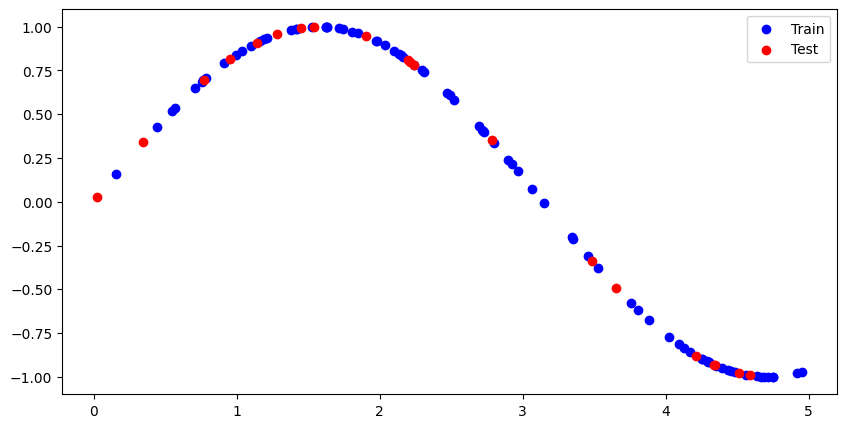

In [4]:
# Creamos datos para evaluar a nuestro modelo
rng = np.random.default_rng(2023)
X = jnp.sort(5 * rng.random(100))[:, None]
y = jnp.sin(X).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Visualizamos los datos
plt.figure(figsize=(10, 5))
plt.scatter(X_train, y_train, c='b', label='Train')
plt.scatter(X_test, y_test, c='r', label='Test')
plt.legend()
plt.show()

* Creamos el modelo

In [5]:
# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=1.0, reg_value=1e-4)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

In [6]:
# Generamos datos para el entrenamiento de nuestro modelos
X_test_range = jnp.linspace(0, 5, 1000)[:, None]

# Hacemos predicciones sobre los datos de entrenamiento que creamos en la linea de
# arriba
y_pred = krr.predict(X_test_range)

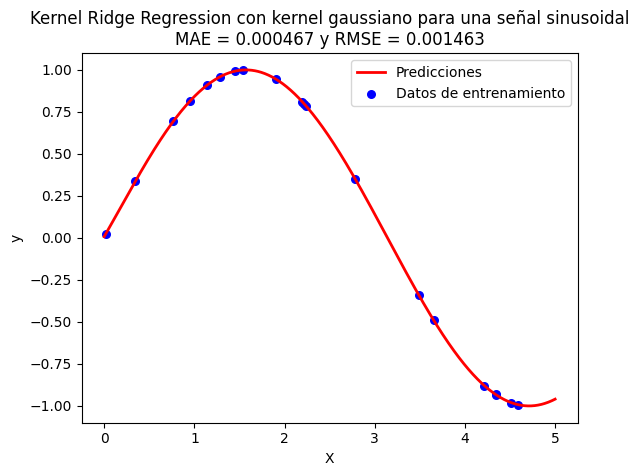

In [7]:
# Calculamos los errores
y_pred_original_test = krr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

# Ploteamos las predicciones
#plt.plot(X_test_range, jnp.sin(X_test_range), label="Señal real", c='g', lw=2)
plt.plot(X_test_range, y_pred, label="Predicciones", c='r', lw=2)
plt.scatter(X_test, y_test, label="Datos de entrenamiento", c='b', s=30)
plt.title(f"Kernel Ridge Regression con kernel gaussiano para una señal sinusoidal\nMAE = {mae:.6f} y RMSE = {rmse:.6f}")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

## Datos Económicos (IPC, PIB, Transporte) y Temperatura

### Datos del clima

In [8]:
lluvia = pd.read_csv('../Data/lluvia_estados_nacional.csv').drop('Unnamed: 0', axis=1)
temperatura = pd.read_csv('../Data/temp_estados_nacional.csv').drop('Unnamed: 0', axis=1)

# Diccionario de las iniciales de los estados de la republica mexicana
estados = {
    'AGUASCALIENTES': 'AGS',
    'BAJA CALIFORNIA': 'BC',
    'BAJA CALIFORNIA SUR': 'BCS',
    'CAMPECHE': 'CAMP',
    'CHIAPAS': 'CHIS',
    'CHIHUAHUA': 'CHIH',
    'COAHUILA': 'COAH',
    'COAHUILA DE ZARAGOZA' : 'COAH',
    'COLIMA': 'COL',
    'DURANGO': 'DGO',
    'GUANAJUATO': 'GTO',
    'GUERRERO': 'GRO',
    'HIDALGO': 'HGO',
    'JALISCO': 'JAL',
    'ESTADO DE MÉXICO': 'MEX',
    'MÉXICO' : 'MEX',
    'MICHOACÁN': 'MICH',
    'MICHOACÁN DE OCAMPO' : 'MICH',
    'MORELOS': 'MOR',
    'NAYARIT': 'NAY',
    'NUEVO LEÓN': 'NL',
    'OAXACA': 'OAX',
    'PUEBLA': 'PUE',
    'QUERÉTARO': 'QRO',
    'QUINTANA ROO': 'QROO',
    'SAN LUIS POTOSÍ': 'SLP',
    'SINALOA': 'SIN',
    'SONORA': 'SON',
    'TABASCO': 'TAB',
    'TAMAULIPAS': 'TAMPS',
    'TLAXCALA': 'TLAX',
    'VERACRUZ': 'VER',
    'VERACRUZ DE IGNACIO DE LA LLAVE' : 'VER',
    'YUCATÁN': 'YUC',
    'ZACATECAS': 'ZAC',
    'DISTRITO FEDERAL': 'CDMX',
    'CIUDAD DE MÉXICO' : 'CDMX',
    'NACIONAL' : 'NACIONAL',
    'ESTADOS UNIDOS MEXICANOS' : 'NACIONAL'
}

# Cambiamos los nombres de las columnas de lluvia y de temperatura y además agregamos al nombre
# un flag de si es lluvia o temperatura
for col in lluvia.columns:
    lluvia.rename(columns={col: f'{estados[col]}_lluvia'}, inplace=True)

for col in temperatura.columns:
    temperatura.rename(columns={col: f'{estados[col]}_temperatura'}, inplace=True)

In [9]:
print(lluvia.shape)  # Los datos son medidas en precipitación (mm) Son datos mensuales
print(temperatura.shape) # Los datos son medidas en temperatura (°C) Son datos mensuales

(464, 33)
(464, 33)


* Hacemos merge de los datos

In [10]:
clima = pd.merge(lluvia, temperatura, left_index=True, right_index=True)
clima

AGS_lluvia  BC_lluvia  BCS_lluvia  CAMP_lluvia  COAH_lluvia  COL_lluvia  \
0           4.9       12.2        30.3         20.9         40.7         8.1   
1           1.6       23.6         0.1         26.7          6.2         1.8   
2           1.9       10.0         0.3         16.5          4.9         0.2   
3          17.6        3.7         0.3          4.2         43.6         0.1   
4          21.5        0.0         0.1        233.4         46.9         1.2   
..          ...        ...         ...          ...          ...         ...   
459         1.0        0.0         0.1         14.6          6.9         0.0   
460         9.6        0.4         0.3         58.4         50.7         1.0   
461         6.7        0.2         1.6         75.4         10.6       137.3   
462        80.9        2.4         7.9        142.7         31.2       280.7   
463        82.7       40.1        83.6        210.2         22.1       217.4   

     CHIS_lluvia  CHIH_lluvia  CDMX_lluvia  DGO_lluvia  ...  SLP_temperatura  \
0          107.3         54.6          1.1        61.3  ...             13.9   
1           59.2          9.4          1.5         4.7  ...             16.0   
2           60.5          5.1          4.7         0.5  ...             20.2   
3          100.1         21.1         52.0        11.4  ...             20.9   
4          111.9          8.1         67.2         6.6  ...             23.5   
..           ...          ...          ...         ...  ...              ...   
459         23.5          1.3         10.1         2.7  ...             24.6   
460         96.6         17.7         43.2        12.0  ...             25.9   
461        207.8         10.0         28.2        11.0  ...             29.0   
462        260.9         37.0        117.6        93.0  ...             27.9   
463        224.6         56.3         97.3        57.8  ...             27.8   

     SIN_temperatura  SON_temperatura  TAB_temperatura  TAMPS_temperatura  \
0               17.8             13.0             22.5               14.0   
1               18.8             14.2             24.1               16.8   
2               21.1             17.0             26.9               22.4   
3               23.4             21.1             27.7               24.1   
4               26.3             24.2             29.1               26.6   
..               ...              ...              ...                ...   
459             24.1             20.5             28.8               24.7   
460             26.9             23.5             30.1               27.4   
461             30.1             28.1             31.3               30.9   
462             31.5             32.8             29.5               31.3   
463             30.9             31.7             29.3               31.1   

     TLAX_temperatura  VER_temperatura  YUC_temperatura  ZAC_temperatura  \
0                11.0             17.7             22.5             11.4   
1                11.7             18.9             24.2             13.8   
2                13.7             22.2             25.8             16.8   
3                14.2             23.8             26.2             17.7   
4                15.2             25.5             27.4             21.3   
..                ...              ...              ...              ...   
459              16.6             24.9             28.8             19.7   
460              17.8             26.2             29.7             21.4   
461              18.7             27.5             30.6             25.0   
462              17.5             25.9             30.4             23.1   
463              17.2             25.7             29.8             22.4   

     NACIONAL_temperatura  
0                    15.6  
1                    17.1  
2                    19.9  
3                    21.0  
4                    23.1  
..                    ...  
459                  22.5  
460                  

In [11]:
# Añadimos a clima una columna de periodo
clima['Periodo'] = pd.date_range(start='1985-01-01', end='2023-08-01', freq='MS')
clima.set_index('Periodo', inplace=True)
clima

AGS_lluvia  BC_lluvia  BCS_lluvia  CAMP_lluvia  COAH_lluvia  \
Periodo                                                                   
1985-01-01         4.9       12.2        30.3         20.9         40.7   
1985-02-01         1.6       23.6         0.1         26.7          6.2   
1985-03-01         1.9       10.0         0.3         16.5          4.9   
1985-04-01        17.6        3.7         0.3          4.2         43.6   
1985-05-01        21.5        0.0         0.1        233.4         46.9   
...                ...        ...         ...          ...          ...   
2023-04-01         1.0        0.0         0.1         14.6          6.9   
2023-05-01         9.6        0.4         0.3         58.4         50.7   
2023-06-01         6.7        0.2         1.6         75.4         10.6   
2023-07-01        80.9        2.4         7.9        142.7         31.2   
2023-08-01        82.7       40.1        83.6        210.2         22.1   

            COL_lluvia  CHIS_lluvia  CHIH_lluvia  CDMX_lluvia  DGO_lluvia  \
Periodo                                                                     
1985-01-01         8.1        107.3         54.6          1.1        61.3   
1985-02-01         1.8         59.2          9.4          1.5         4.7   
1985-03-01         0.2         60.5          5.1          4.7         0.5   
1985-04-01         0.1        100.1         21.1         52.0        11.4   
1985-05-01         1.2        111.9          8.1         67.2         6.6   
...                ...          ...          ...          ...         ...   
2023-04-01         0.0         23.5          1.3         10.1         2.7   
2023-05-01         1.0         96.6         17.7         43.2        12.0   
2023-06-01       137.3        207.8         10.0         28.2        11.0   
2023-07-01       280.7        260.9         37.0        117.6        93.0   
2023-08-01       217.4        224.6         56.3         97.3        57.8   

            ...  SLP_temperatura  SIN_temperatura  SON_temperatura  \
Periodo     ...                                                      
1985-01-01  ...             13.9             17.8             13.0   
1985-02-01  ...             16.0             18.8             14.2   
1985-03-01  ...             20.2             21.1             17.0   
1985-04-01  ...             20.9             23.4             21.1   
1985-05-01  ...             23.5             26.3             24.2   
...         ...              ...              ...              ...   
2023-04-01  ...             24.6             24.1             20.5   
2023-05-01  ...             25.9             26.9             23.5   
2023-06-01  ...             29.0             30.1             28.1   
2023-07-01  ...             27.9             31.5             32.8   
2023-08-01  ...             27.8             30.9             31.7   

            TAB_temperatura  TAMPS_temperatura  TLAX_temperatura  \
Periodo                                                            
1985-01-01             22.5               14.0              11.0   
1985-02-01             24.1               16.8              11.7   
1985-03-01             26.9               22.4              13.7   
1985-04-01             27.7               24.1              14.2   
1985-05-01             29.1               26.6              15.2   
...                     ...                ...               ...   
2023-04-01             28.8               24.7              16.6   
2023-05-01             30.1               27.4              17.8   
2023-06-01             31.3               30.9              18.7   
2023-07-01             29.5               31.3              17.5   
2023-08-01             29.3               31.1              17.2   

            VER_temperatura  YUC_temperatura  ZAC_temperatura  \
Periodo                                                         
1985-01-01             17.7             22.5             11.4   
1985-02-01             18.9             24.

### Datos del IPC (Mensuales) - Desde 1980 a 2023

* IPC (Indice de Precios y Cotizaciones)
* En pesos mexicanos

In [12]:
ipc = pd.read_excel('../Data/IPC de la BMV 1980-2023.xlsx', sheet_name='Mensual')
# Eliminamos la primera fila que no contiene datos
ipc.drop([0,1,2], inplace=True)
# Renombramos las columnas
ipc.columns = ['Fecha', 'Cierre']
ipc.reset_index(drop=True, inplace=True)
# To date Fecha
ipc['Fecha'] = pd.date_range(start='1980-12-01', end='2023-09-01', freq='MS')
ipc.set_index('Fecha', inplace=True)
ipc

Cierre
Fecha               
1980-12-01    1.4322
1981-01-01    1.4793
1981-02-01    1.4056
1981-03-01    1.3432
1981-04-01    1.3229
...              ...
2023-05-01  52736.26
2023-06-01   53526.1
2023-07-01  54819.05
2023-08-01  53020.98
2023-09-01  50874.98

[514 rows x 1 columns]

### Datos del PIB - Desde 1980 hasta 2023

#### Datos del PIB (Trimestrales)

* Periodo trimestral desde 1980
* En pesos mexicanos
* Cuentas nacionales > Producto interno bruto trimestral, base 2018 > Valores a precios de 2018 > Producto Interno Bruto /a /f1 (Millones de pesos a precios de 2018.)  Trimestral

Notas:
* /a  Ello implica que, los datos resultantes de cada trimestre se multiplicaron por cuatro para expresarlos en niveles anuales, con lo cual se facilita la comparación de los resultados trimestrales con los anuales.  La suma de los parciales, puede  no ser igual al total debido al redondeo a millones de pesos.  Este producto se actualiza una vez que se dispone de la información estadística más reciente de las Cuentas de Bienes y Servicios 2022 versión preliminar que originó cambios desde 2019 a 2022; así como, de las encuestas, los registros administrativos y los datos primarios para los años 2021, 2022 y 2023. Como resultado de incorporar esta información,  se identifican diferencias en los niveles de los valores y variaciones que se publicaron oportunamente. La actualización se hace con base en los «Lineamientos de cambios a la información divulgada en las publicaciones estadísticas  y  geográficas del Instituto Nacional de Estadística y Geografía» que se complementan con las Normas Especiales para la Divulgación de Datos del Fondo Monetario Internacional (FMI).

Cifras Preliminares:
* /p1 A partir de 2023/03

Cifras Revisadas:
* /r1 A partir de 2019/01

Fuentes:
* /f1 INEGI. Sistema de Cuentas Nacionales de México.

In [13]:
pib = pd.read_excel('../Data/PIB trimestral Mexico 1980-2023.xlsx')
pib.drop([0,1,2,3], inplace=True)
pib.columns = ['Fecha', 'PIB']
pib.reset_index(drop=True, inplace=True)
pib.drop(list(range(175, 184)), inplace=True)
pib.reset_index(drop=True, inplace=True)
pib
# # Fechas
# pib['Fecha'] = pd.date_range(start='1980-01-01', end='2023-09-01', freq='MS')
# pib.set_index('Fecha', inplace=True)
# pib

Fecha           PIB
0        1980/01  10401367.607
1        1980/02      10342350
2        1980/03  10392733.012
3        1980/04  10927666.353
4        1981/01  11345848.491
..           ...           ...
170      2022/03  24313828.684
171      2022/04  24974759.698
172      2023/01  24251720.859
173      2023/02  24997299.298
174  2023/03 /p1  25118230.778

[175 rows x 2 columns]

#### Datos del PIB Mensuales

In [14]:
pibm = pd.read_csv('../Data/pip_mensual.csv')
pibm.Fecha = pd.to_datetime(pibm.Fecha)
pibm.set_index('Fecha', inplace=True)
pibm.tail()

Estados Unidos Mexicanos            Aguascalientes  \
Fecha                                                                      
2023-02-28                          100.301509                 96.045582   
2023-03-31                          100.301509                 96.045582   
2023-04-30                          103.723838                100.892599   
2023-05-31                          103.723838                100.892599   
2023-06-30                          103.723838                100.892599   

                      Baja California            Baja California Sur  \
Fecha                                                                  
2023-02-28                 105.915157                      97.380060   
2023-03-31                 105.915157                      97.380060   
2023-04-30                 110.407816                     102.110933   
2023-05-31                 110.407816                     102.110933   
2023-06-30                 110.407816                     102.110933   

                      Campeche            Coahuila de Zaragoza  \
Fecha                                                            
2023-02-28           84.286107                       95.768807   
2023-03-31           84.286107                       95.768807   
2023-04-30           89.644697                       97.616243   
2023-05-31           89.644697                       97.616243   
2023-06-30           89.644697                       97.616243   

                      Colima            Chiapas            Chihuahua  \
Fecha                                                                  
2023-02-28         96.426424         108.254043           102.057815   
2023-03-31         96.426424         108.254043           102.057815   
2023-04-30        100.180883         107.604109           106.759006   
2023-05-31        100.180883         107.604109           106.759006   
2023-06-30        100.180883         107.604109           106.759006   

                      Ciudad de México  ...            Quintana Roo  \
Fecha                                   ...                           
2023-02-28                   97.358416  ...              104.135821   
2023-03-31                   97.358416  ...              104.135821   
2023-04-30                  100.811933  ...              107.688055   
2023-05-31                  100.811933  ...              107.688055   
2023-06-30                  100.811933  ...              107.688055   

                      San Luis Potosí            Sinaloa            Sonora  \
Fecha                                                                        
2023-02-28                 100.274601         101.415633        103.197026   
2023-03-31                 100.274601         101.415633        103.197026   
2023-04-30                 103.525119          99.820137        108.440756   
2023-05-31                 103.525119          99.820137        108.440756   
2023-06-30                 103.525119          99.820137        108.440756   

                      Tabasco            Tamaulipas            Tlaxcala  \
Fecha                                                                     
2023-02-28         138.520788            101.177592           95.391397   
2023-03-31         138.520788            101.177592           95.391397   
2023-04-30         148.246536            101.986999          103.439072   
2023-05-31         148.246536            101.986999          103.439072   
2023-06-30         148.246536            101.986999          103.439072   

                      Veracruz de Ignacio de la Llave            Yucatán  \
Fecha                                                                      
2023-02-28                                 102.908287         100.956770   
2023-03-31                                 102.908287         100.956770   
2023-04-30                                 103.553552         104.994836   
2023-05-31                                 103.553552         104

In [15]:
# Cambiar los nombres de las columnas y poner la abreviatura del estado y que es del pib
for col in pibm.columns:
    col_dic = col.upper().strip()
    pibm.rename(columns={col: f'{str(estados[col_dic])}_pib'}, inplace=True)    

pibm.head()

NACIONAL_pib    AGS_pib     BC_pib    BCS_pib    CAMP_pib  \
Fecha                                                                   
1981-01-31     46.812594  24.496731  46.567038  30.344115   99.769432   
1981-02-28     46.812594  24.496731  46.567038  30.344115   99.769432   
1981-03-31     46.812594  24.496731  46.567038  30.344115   99.769432   
1981-04-30     47.702490  25.164577  51.401800  31.495767  101.194826   
1981-05-31     47.702490  25.164577  51.401800  31.495767  101.194826   

             COAH_pib    COL_pib   CHIS_pib   CHIH_pib   CDMX_pib  ...  \
Fecha                                                              ...   
1981-01-31  40.314528  42.960620  61.055711  36.555678  53.677544  ...   
1981-02-28  40.314528  42.960620  61.055711  36.555678  53.677544  ...   
1981-03-31  40.314528  42.960620  61.055711  36.555678  53.677544  ...   
1981-04-30  42.172765  44.648219  59.525269  38.893616  53.904489  ...   
1981-05-31  42.172765  44.648219  59.525269  38.893616  53.904489  ...   

             QROO_pib    SLP_pib    SIN_pib    SON_pib    TAB_pib  TAMPS_pib  \
Fecha                                                                          
1981-01-31  26.372766  35.989280  53.141525  42.433515  60.800845  46.865467   
1981-02-28  26.372766  35.989280  53.141525  42.433515  60.800845  46.865467   
1981-03-31  26.372766  35.989280  53.141525  42.433515  60.800845  46.865467   
1981-04-30  26.393933  36.862548  50.804566  46.335414  62.876342  45.152994   
1981-05-31  26.393933  36.862548  50.804566  46.335414  62.876342  45.152994   

             TLAX_pib    VER_pib    YUC_pib    ZAC_pib  
Fecha                                                   
1981-01-31  45.497769  64.904801  37.450990  31.225662  
1981-02-28  45.497769  64.904801  37.450990  31.225662  
1981-03-31  45.497769  64.904801  37.450990  31.225662  
1981-04-30  47.314243  62.794704  38.084341  34.368472  
1981-05-31  47.314243  62.794704  38.084341  34.368472  

[5 rows x 33 columns]

In [16]:
new_idx = []
for i in pibm.index:
    new_idx.append(i.replace(day=1))

pibm.index = new_idx

### Datos del Transporte (Mensuales) - Desde 1991 a 2023

Notas:
* /a  La Estadística Mensual de Vehículos de Motor Registrados en Circulación se actualiza a partir del padrón vehicular registrado  por  los  gobiernos  de  las 32 entidades federativas, al 31 de diciembre del año inmediato anterior. Posteriormente, en los meses del año en curso se realiza una estimación del parque vehicular mensual en circulación, incorporando las ventas de vehículos al público reportadas en el Registro Administrativo de la Industria Automotriz de Vehículos Ligeros (RAIAVL) y el Registro Administrativo de la Industria Automotriz de Vehículos Pesados (RAIAVP). En este sentido, los datos publicados mensualmente se actualizan  hasta la publicación de cifras anuales de Vehículos de Motor Registrados en Circulación. Asimismo, la Estadística Mensual de Vehículos de Motor Registrados en Circulación excluye los datos de Motocicletas y del servicio Oficial.

Cifras Preliminares:
* /p1 A partir de 2022/01

Fuentes:
* /f1 INEGI. RAIAVL. Cifras a partir de 2015; INEGI. RAIAVP. Cifras a partir de 2018; INEGI. EMIM. Cifras de 2015 a 2018; AMIA. Cifras hasta 2015; ANPACT. Cifras hasta 2015.

In [17]:
transporte = pd.read_excel('../Data/Transporte vehículos 1991-2023.xlsx')
transporte.drop([0,1,2,3], inplace=True)
transporte.columns = ['Fecha', 'Automóviles', 'Camiones y camionetas para carga', 'Camiones para pasajeros', 'Total']
transporte.reset_index(drop=True, inplace=True)
transporte.tail(10)
transporte.drop(list(range(394, 401)), inplace=True)
transporte.reset_index(drop=True, inplace=True)

# Fechas
transporte['Fecha'] = pd.date_range(start='1991-01-01', end='2023-10-01', freq='MS')
transporte.set_index('Fecha', inplace=True)
transporte

Automóviles Camiones y camionetas para carga  \
Fecha                                                     
1991-01-01     6555657                          2974505   
1991-02-01     6587943                          3000866   
1991-03-01     6620305                          3027412   
1991-04-01     6652751                          3054153   
1991-05-01     6685285                          3081098   
...                ...                              ...   
2023-06-01    36714021                         11436347   
2023-07-01    36761643                         11460396   
2023-08-01    36812412                         11484755   
2023-09-01    36862881                         11509416   
2023-10-01    36911736                         11531726   

           Camiones para pasajeros     Total  
Fecha                                         
1991-01-01                   90697   9620859  
1991-02-01                   90974   9679783  
1991-03-01                   91251   9738968  
1991-04-01                   91530   9798434  
1991-05-01                   91810   9858193  
...                            ...       ...  
2023-06-01                  711513  48861881  
2023-07-01                  755019  48977058  
2023-08-01                  798494  49095661  
2023-09-01                  845862  49218159  
2023-10-01                  893055  49336517  

[394 rows x 4 columns]

**Nota:**

Haremos el proyecto utilizando el IPC y el de transporte, ya que el PIB es trimestral y además que el PIB tiene una correlación muy alta con el IPC.

### Juntamos los datos

#### Datos de IDA

* El rango elegido es de 1991 (Enero 01) a 2023 (Agosto 08)

In [18]:
# Nos agarramos los datos de enero 1991 a agosto 2023
ipc = ipc.loc['1991-01-01':'2023-08-01']
transporte = transporte.loc['1991-01-01':'2023-08-01']['Total']
clima = clima.loc['1991-01-01':'2023-08-01']
#pibm = pibm.loc['1991-01-01':'2023-06-30']

# Hacemos merge de las tres tablas
datos = pd.merge(ipc, transporte, left_index=True, right_index=True)
datos = pd.merge(datos, clima, left_index=True, right_index=True)
#datos = pd.merge(datos, pibm, left_index=True, right_index=True)
#datos.to_csv('../Data/DatosOriginales.csv', index=True)
datos.head()

Cierre    Total  AGS_lluvia  BC_lluvia  BCS_lluvia  \
Fecha                                                               
1991-01-01    622.985  9620859         0.0        7.3         9.3   
1991-02-01    659.165  9679783        19.6       23.7        14.7   
1991-03-01    803.347  9738968         0.0       40.9         2.8   
1991-04-01     901.14  9798434         0.0        0.0         0.0   
1991-05-01  1096.1699  9858193         3.7        0.0         0.0   

            CAMP_lluvia  COAH_lluvia  COL_lluvia  CHIS_lluvia  CHIH_lluvia  \
Fecha                                                                        
1991-01-01         50.5         14.1         1.0         31.0         21.6   
1991-02-01         71.9         23.2         2.5         11.0         25.3   
1991-03-01          5.2          8.2         0.0          6.5          4.3   
1991-04-01          5.7         18.2         0.0         42.8          0.9   
1991-05-01         84.1         12.7         0.0        125.6          0.0   

            ...  SLP_temperatura  SIN_temperatura  SON_temperatura  \
Fecha       ...                                                      
1991-01-01  ...             16.3             19.1             13.8   
1991-02-01  ...             16.8             20.8             16.7   
1991-03-01  ...             21.2             20.9             16.2   
1991-04-01  ...             23.6             23.9             20.0   
1991-05-01  ...             25.4             25.9             23.3   

            TAB_temperatura  TAMPS_temperatura  TLAX_temperatura  \
Fecha                                                              
1991-01-01             25.6               17.4              11.7   
1991-02-01             24.3               19.0              13.1   
1991-03-01             27.6               23.9              15.8   
1991-04-01             30.1               26.7              16.9   
1991-05-01             30.4               27.9              16.5   

            VER_temperatura  YUC_temperatura  ZAC_temperatura  \
Fecha                                                           
1991-01-01             19.6             24.6             12.3   
1991-02-01             19.4             24.0             13.7   
1991-03-01             23.5             26.2             16.7   
1991-04-01             26.0             28.3             19.1   
1991-05-01             26.9             28.7             21.4   

            NACIONAL_temperatura  
Fecha                             
1991-01-01                  17.0  
1991-02-01                  18.0  
1991-03-01                  20.4  
1991-04-01                  22.5  
1991-05-01                  23.6  

[5 rows x 68 columns]

In [19]:
datos.shape 

(392, 68)

In [20]:
datos_diffs = datos.diff()
print(datos_diffs.shape)
datos_diffs.dropna(inplace=True)
print(datos_diffs.shape)

(392, 68)
(391, 68)


In [21]:
datos_diffs

Cierre   Total  AGS_lluvia  BC_lluvia  BCS_lluvia  CAMP_lluvia  \
Fecha                                                                          
1991-02-01     36.18   58924        19.6       16.4         5.4         21.4   
1991-03-01   144.182   59185       -19.6       17.2       -11.9        -66.7   
1991-04-01    97.793   59466         0.0      -40.9        -2.8          0.5   
1991-05-01  195.0299   59759         3.7        0.0         0.0         78.4   
1991-06-01    -38.15   60038        68.3        0.0         0.0         31.0   
...              ...     ...         ...        ...         ...          ...   
2023-04-01   1217.22  101457         0.9      -24.5        -0.9        -18.5   
2023-05-01  -2384.96  111416         8.6        0.4         0.2         43.8   
2023-06-01    789.84  118088        -2.9       -0.2         1.3         17.0   
2023-07-01   1292.95  115177        74.2        2.2         6.3         67.3   
2023-08-01  -1798.07  118603         1.8       37.7        75.7         67.5   

            COAH_lluvia  COL_lluvia  CHIS_lluvia  CHIH_lluvia  ...  \
Fecha                                                          ...   
1991-02-01          9.1         1.5        -20.0          3.7  ...   
1991-03-01        -15.0        -2.5         -4.5        -21.0  ...   
1991-04-01         10.0         0.0         36.3         -3.4  ...   
1991-05-01         -5.5         0.0         82.8         -0.9  ...   
1991-06-01         78.1        83.6        125.1         30.6  ...   
...                 ...         ...          ...          ...  ...   
2023-04-01         -5.9         0.0        -14.7        -17.6  ...   
2023-05-01         43.8         1.0         73.1         16.4  ...   
2023-06-01        -40.1       136.3        111.2         -7.7  ...   
2023-07-01         20.6       143.4         53.1         27.0  ...   
2023-08-01         -9.1       -63.3        -36.3         19.3  ...   

            SLP_temperatura  SIN_temperatura  SON_temperatura  \
Fecha                                                           
1991-02-01              0.5              1.7              2.9   
1991-03-01              4.4              0.1             -0.5   
1991-04-01              2.4              3.0              3.8   
1991-05-01              1.8              2.0              3.3   
1991-06-01             -1.0              3.5              3.7   
...                     ...              ...              ...   
2023-04-01              0.9              2.3              3.0   
2023-05-01              1.3              2.8              3.0   
2023-06-01              3.1              3.2              4.6   
2023-07-01             -1.1              1.4              4.7   
2023-08-01             -0.1             -0.6             -1.1   

            TAB_temperatura  TAMPS_temperatura  TLAX_temperatura  \
Fecha                                                              
1991-02-01             -1.3                1.6               1.4   
1991-03-01              3.3                4.9               2.7   
1991-04-01              2.5                2.8               1.1   
1991-05-01              0.3                1.2              -0.4   
1991-06-01             -0.5                0.2              -0.8   
...                     ...                ...               ...   
2023-04-01              0.5                0.0               0.3   
2023-05-01              1.3                2.7               1.2   
2023-06-01              1.2                3.5               0.9   
2023-07-01             -1.8                0.4              -1.2   
2023-08-01             -0.2               -0.2              -0.3   

            VER_temperatura  YUC_temperatura  ZAC_temperatura  \
Fecha                                                           
1991-02-01             -0.2             -0.6              1.4   
1991-03-01              4.1              2.2              3.0   
1991-04-01              2.5              2.1              2.4   
1991-0

In [22]:
scaler = StandardScaler()
datos_scaled = scaler.fit_transform(datos)

datos_df = pd.DataFrame(datos_scaled, columns=datos.columns, index=datos.index)
datos_df.rename(columns={'Total': 'Transporte'}, inplace=True)
datos_df.rename(columns={'Cierre': 'IPC'}, inplace=True)
datos_df.head()

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767

IPC  Transporte  AGS_lluvia  BC_lluvia  BCS_lluvia  \
Fecha                                                                 
1991-01-01 -1.245205   -1.298902   -0.783887  -0.313929   -0.238387   
1991-02-01 -1.243262   -1.294263   -0.428814   0.327437   -0.062261   
1991-03-01 -1.235519   -1.289603   -0.783887   1.000090   -0.450389   
1991-04-01 -1.230268   -1.284921   -0.783887  -0.599415   -0.541714   
1991-05-01 -1.219795   -1.280216   -0.716858  -0.599415   -0.541714   

            CAMP_lluvia  COAH_lluvia  COL_lluvia  CHIS_lluvia  CHIH_lluvia  \
Fecha                                                                        
1991-01-01    -0.662178    -0.546863   -0.707251    -0.974857    -0.357486   
1991-02-01    -0.436837    -0.273393   -0.696488    -1.123238    -0.273941   
1991-03-01    -1.139185    -0.724168   -0.714426    -1.156624    -0.748115   
1991-04-01    -1.133920    -0.423651   -0.714426    -0.887311    -0.824886   
1991-05-01    -0.308372    -0.588935   -0.714426    -0.273011    -0.845208   

            ...  SLP_temperatura  SIN_temperatura  SON_temperatura  \
Fecha       ...                                                      
1991-01-01  ...        -1.615210        -1.535247        -1.476689   
1991-02-01  ...        -1.476947        -1.111257        -0.985683   
1991-03-01  ...        -0.260231        -1.086316        -1.070340   
1991-04-01  ...         0.403432        -0.338098        -0.426952   
1991-05-01  ...         0.901179         0.160714         0.131779   

            TAB_temperatura  TAMPS_temperatura  TLAX_temperatura  \
Fecha                                                              
1991-01-01        -0.649769          -1.561327         -1.670795   
1991-02-01        -1.245312          -1.189139         -0.926834   
1991-03-01         0.266452          -0.049313          0.507949   
1991-04-01         1.411727           0.602017          1.092490   
1991-05-01         1.549160           0.881158          0.879929   

            VER_temperatura  YUC_temperatura  ZAC_temperatura  \
Fecha                                                           
1991-01-01        -1.357452        -0.868353        -1.539632   
1991-02-01        -1.434421        -1.143679        -1.111376   
1991-03-01         0.143432        -0.134151        -0.193683   
1991-04-01         1.105538         0.829489         0.540471   
1991-05-01         1.451896         1.013039         1.244035   

            NACIONAL_temperatura  
Fecha                             
1991-01-01             -1.400450  
1991-02-01             -1.090626  
1991-03-01             -0.347050  
1991-04-01              0.303580  
1991-05-01              0.644386  

[5 rows x 68 columns]

#### Datos de Regreso

In [23]:
# Nos agarramos los datos de enero 1991 a junio 2023
ipc = ipc.loc['1991-01-01':'2023-06-01']
transporte = transporte.loc['1991-01-01':'2023-06-01']
clima = clima.loc['1991-01-01':'2023-06-01']
pibm = pibm.loc['1991-01-01':'2023-06-01']

# Hacemos merge de las tres tablas
datos_regreso = pd.merge(ipc, transporte, left_index=True, right_index=True)
datos_regreso = pd.merge(datos_regreso, clima, left_index=True, right_index=True)
datos_regreso = pd.merge(datos_regreso, pibm, left_index=True, right_index=True)
#datos_regreso.to_csv('../Data/DatosOriginales.csv', index=True)
datos_regreso.head()

Cierre    Total  AGS_lluvia  BC_lluvia  BCS_lluvia  \
Fecha                                                               
1991-01-01    622.985  9620859         0.0        7.3         9.3   
1991-02-01    659.165  9679783        19.6       23.7        14.7   
1991-03-01    803.347  9738968         0.0       40.9         2.8   
1991-04-01     901.14  9798434         0.0        0.0         0.0   
1991-05-01  1096.1699  9858193         3.7        0.0         0.0   

            CAMP_lluvia  COAH_lluvia  COL_lluvia  CHIS_lluvia  CHIH_lluvia  \
Fecha                                                                        
1991-01-01         50.5         14.1         1.0         31.0         21.6   
1991-02-01         71.9         23.2         2.5         11.0         25.3   
1991-03-01          5.2          8.2         0.0          6.5          4.3   
1991-04-01          5.7         18.2         0.0         42.8          0.9   
1991-05-01         84.1         12.7         0.0        125.6          0.0   

            ...   QROO_pib    SLP_pib    SIN_pib    SON_pib    TAB_pib  \
Fecha       ...                                                          
1991-01-01  ...  31.402227  40.306531  60.192350  46.277640  71.664782   
1991-02-01  ...  31.402227  40.306531  60.192350  46.277640  71.664782   
1991-03-01  ...  31.402227  40.306531  60.192350  46.277640  71.664782   
1991-04-01  ...  32.431963  42.556025  60.200809  51.838437  75.257338   
1991-05-01  ...  32.431963  42.556025  60.200809  51.838437  75.257338   

            TAMPS_pib   TLAX_pib    VER_pib    YUC_pib    ZAC_pib  
Fecha                                                              
1991-01-01  53.116485  52.653841  75.076973  43.518668  39.595277  
1991-02-01  53.116485  52.653841  75.076973  43.518668  39.595277  
1991-03-01  53.116485  52.653841  75.076973  43.518668  39.595277  
1991-04-01  52.556025  55.920182  74.755245  45.547151  44.155506  
1991-05-01  52.556025  55.920182  74.755245  45.547151  44.155506  

[5 rows x 101 columns]

In [24]:
datos_regreso_diff = datos_regreso.diff()

print(datos_regreso_diff.shape)
datos_regreso_diff.dropna(inplace=True)
print(datos_regreso_diff.shape)

(390, 101)
(389, 101)


## Análisis de Correlaciones

* Heatmap

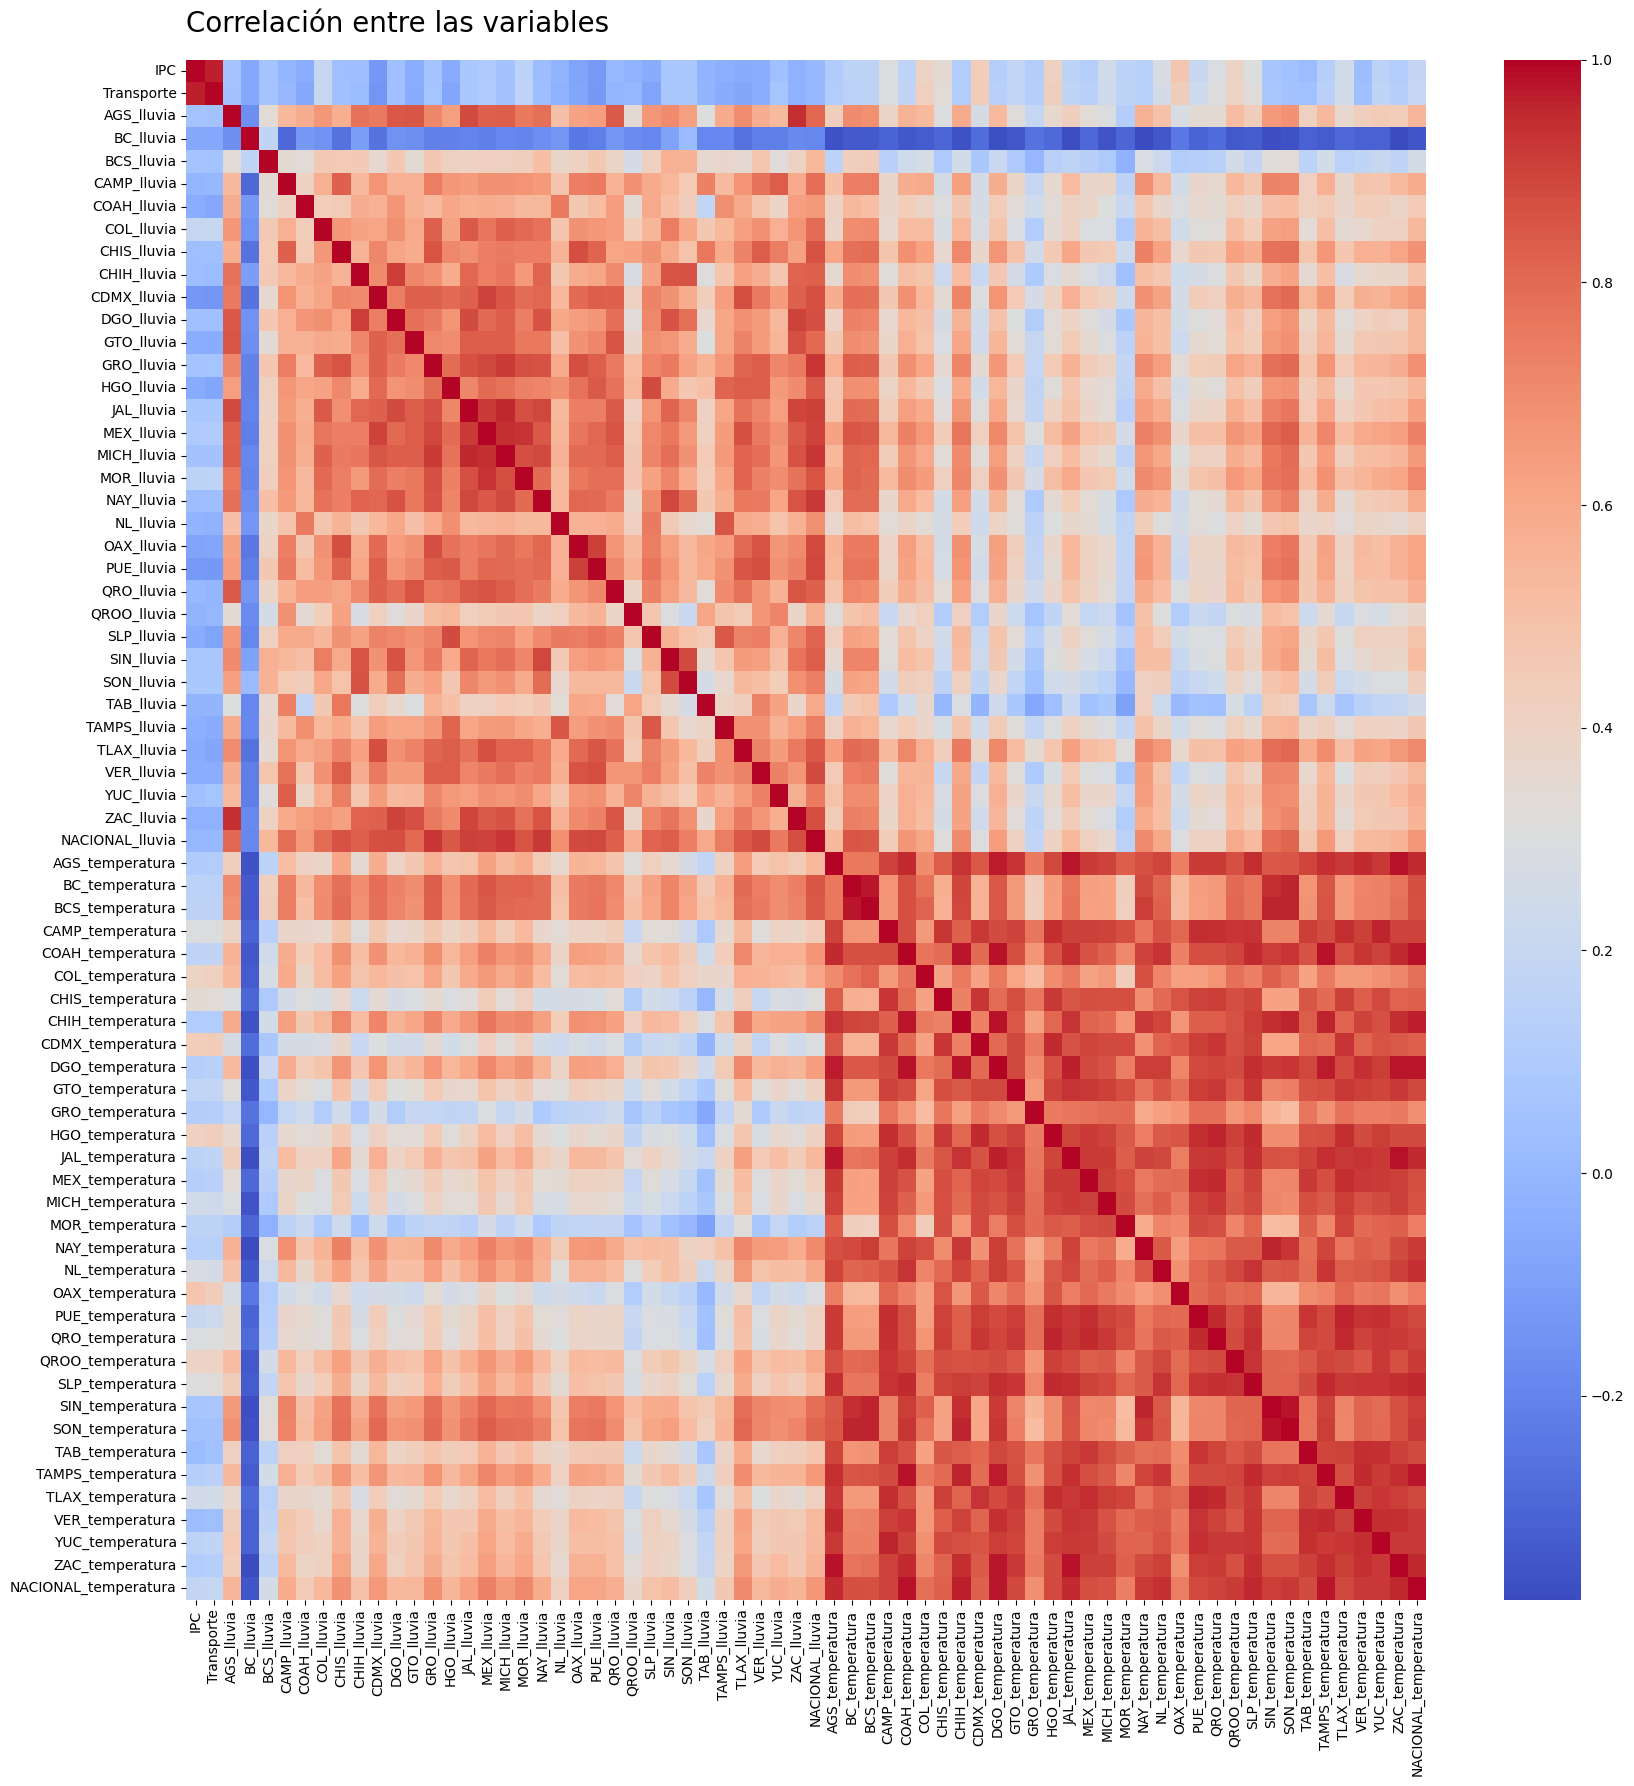

In [25]:
plt.figure(figsize=(20, 20))
sns.heatmap(datos_df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlación entre las variables', fontsize=20, loc='left', pad=20)
plt.show()

## Modelo KRR

### IDA (Datos Coches, Lluvia y Temperatura  --- predecir ---> IPC)

* Obtenemos los datos con los que trabajaremos

In [26]:
X = jnp.array(datos.drop('Cierre', axis=1), dtype=np.float32)
y = jnp.array(datos['Cierre'], dtype=np.float32)

In [27]:
X.shape

(392, 67)

* Hacemos una separación de los datos para entrenamiento y prueba

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [29]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.01, reg_value=1e-4)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

* Traemos las escalas originales

In [30]:
mean = scaler_y.mean_[0]
scale = scaler_y.scale_[0]

y_test = (y_test * scale) + mean
y_pred_original_test = (y_pred_original_test * scale) + mean

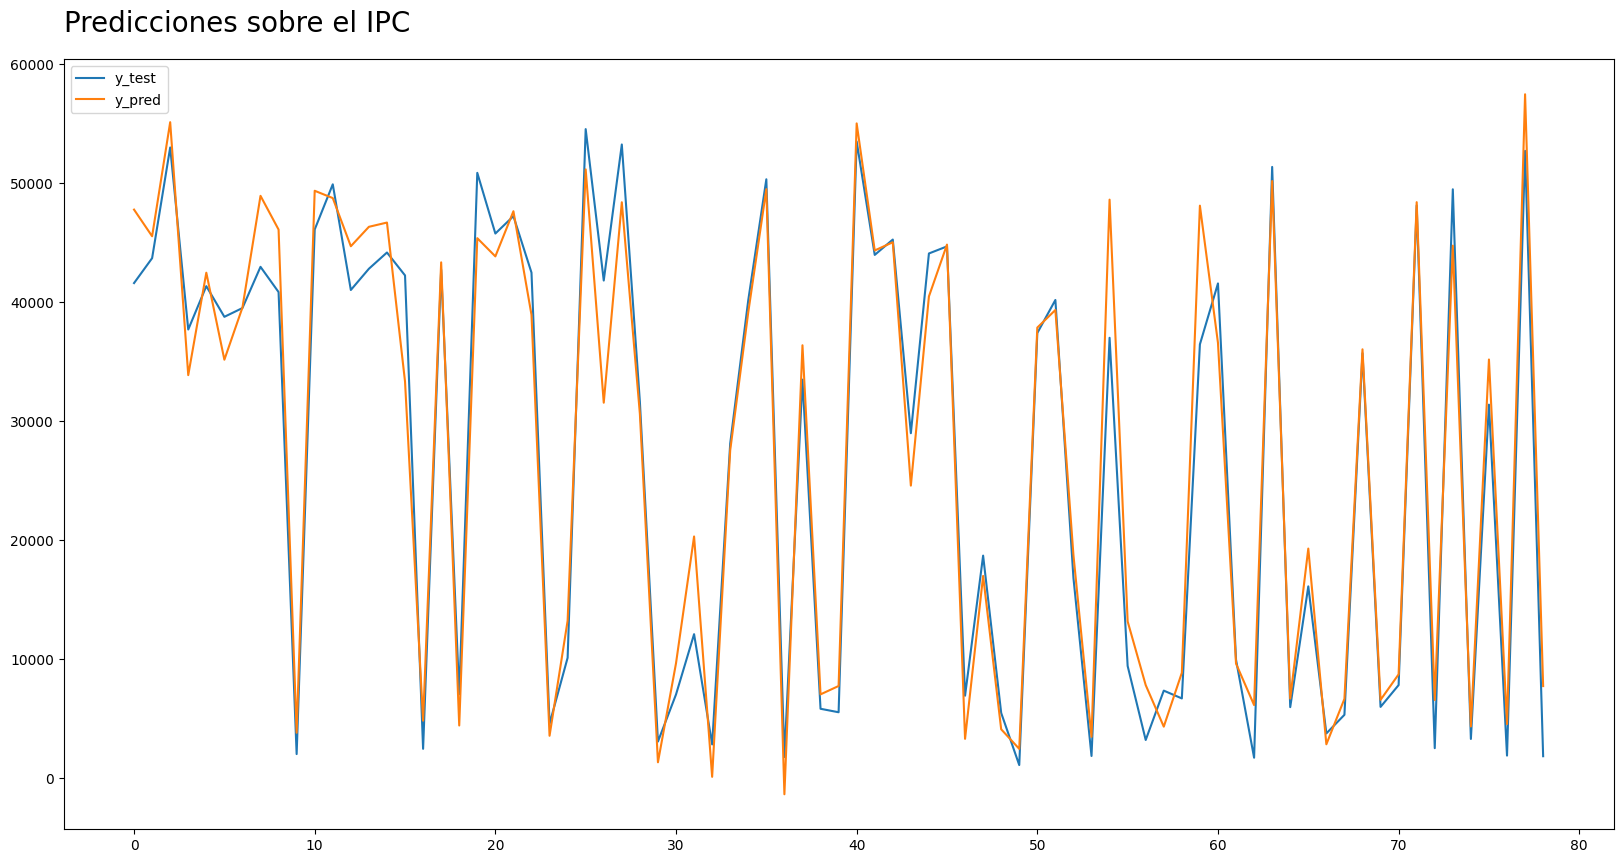

In [31]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre el IPC', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [32]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [33]:
mae, rmse

(2895.239, 3815.1218)

In [34]:
ipc['Cierre'].astype(float).describe()

count      390.000000
mean     23657.016497
std      18568.023306
min        622.985000
25%       5089.785000
50%      22158.715000
75%      42703.452500
max      56536.680000
Name: Cierre, dtype: float64

### Regreso (IPC, PIB (Mensual), Coches --- predecir ---> Lluvia y Temperatura)

**2** modelos distitnos uno para lluvia y otro para temperatura

* Obtenemos los datos con los que trabajaremos

In [35]:
# Todas las columnas que no tengan _lluvia o _temperatura
cols = []
for col in datos_regreso.columns:
    if '_lluvia' not in col and '_temperatura' not in col:
        cols.append(col)

In [36]:
# Todas las columnas que no tengan _lluvia o _temperatura
for col in datos_regreso.columns:
    if 'NACIONAL' in col:
        print(col)

NACIONAL_lluvia
NACIONAL_temperatura
NACIONAL_pib


#### Temperatura Nacional

In [37]:
# Todos los datos financieros y de coches
X = jnp.array(datos_regreso[cols], dtype=np.float32)

# La primera será la temperatura nacional
y = jnp.array(datos_regreso['NACIONAL_temperatura'], dtype=np.float32)

* Hacemos una separación de los datos para entrenamiento y prueba

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [39]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.01, reg_value=0.004)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

In [40]:
media = scaler_y.mean_[0]
desviacion = scaler_y.scale_[0]

y_test = (y_test * desviacion) + media
y_pred_original_test = (y_pred_original_test * desviacion) + media

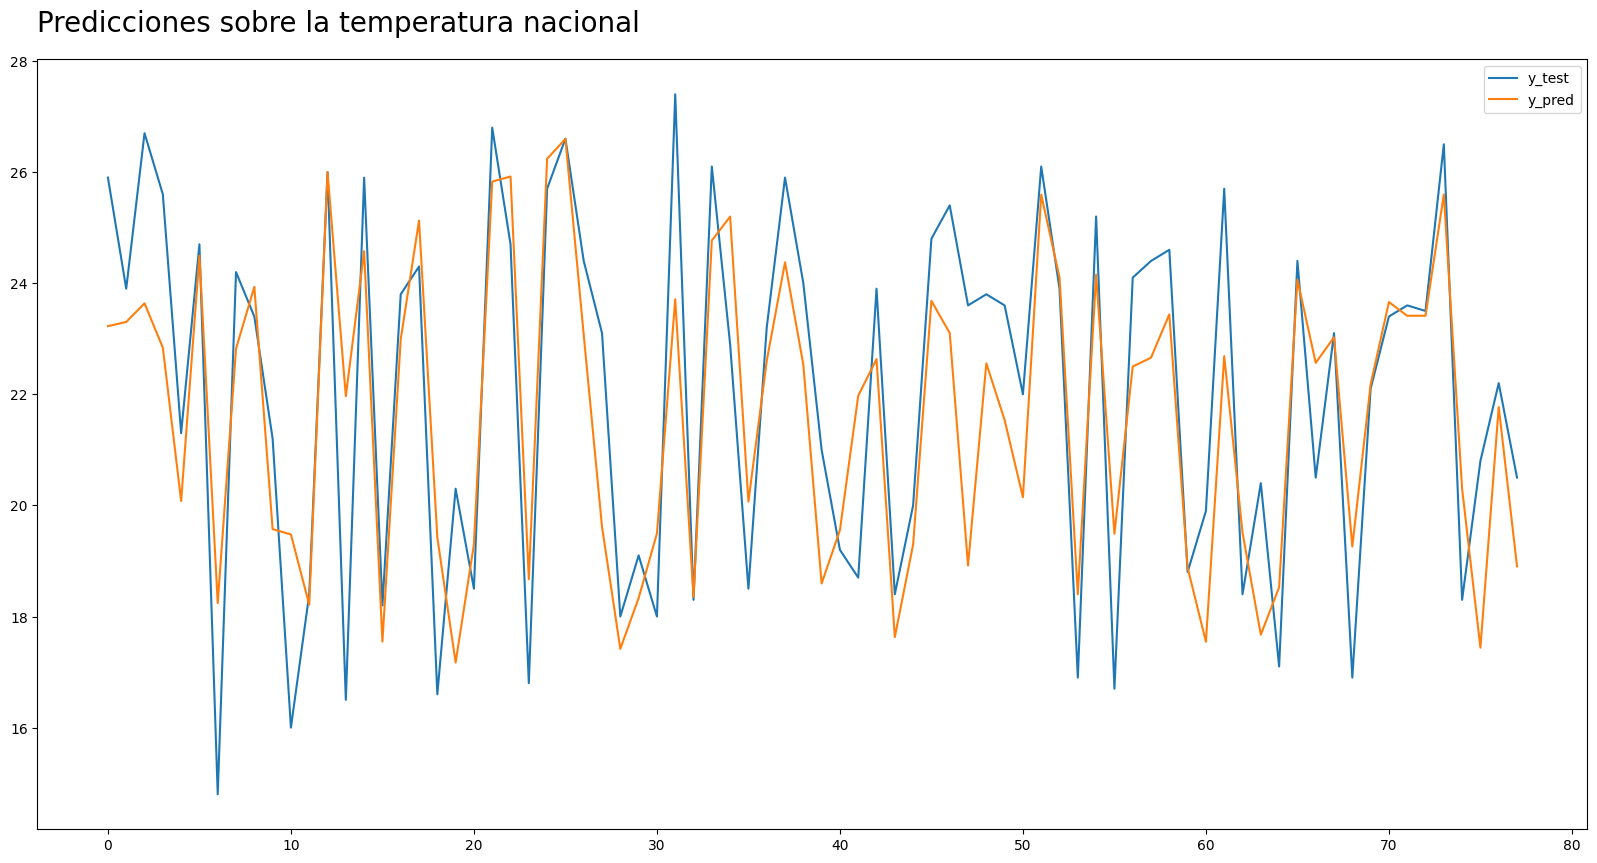

In [41]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre la temperatura nacional', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [42]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [43]:
mae, rmse

(1.5233759, 1.9200169)

**GridSearch**

In [44]:
# Define a range of hyperparameter values for the grid search
params_values = [0.1, 0.01, 0.001, 0.0001, 0.009, 0.007, 0.005, 0.006]
reg_values = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0.02, 0.03, 0.04, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002]
kernels = ['gaussian']

# Initialize variables to store the best hyperparameters and model performance
best_params = None
best_score = float('inf')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Perform grid search
for params_value in params_values:
    for reg_value in reg_values:
        # Create a new instance of the KernelRidgeRegression class with current hyperparameters
        model = KernelRidgeRegression(params=params_value, reg_value=reg_value, kernel='gaussian')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        media = scaler_y.mean_[0]
        desviacion = scaler_y.scale_[0]

        y_pred = (y_pred * desviacion) + media
        
        # Evaluate the performance using a metric (e.g., mean squared error)
        score = mean_absolute_error(y_test, y_pred)

        # Check if the current set of hyperparameters gives a better performance
        if score < best_score:
            best_score = score
            best_params = {'params': params_value, 'reg_value': reg_value, 'kernel': 'gaussian'}

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'params': 0.01, 'reg_value': 0.004, 'kernel': 'gaussian'}
Best Mean Squared Error: 1.5233759


#### Temperatura EDO MEX

In [45]:
# Todos los datos financieros y de coches
X = jnp.array(datos_regreso[cols], dtype=np.float32)

# La primera será la temperatura nacional
y = jnp.array(datos_regreso['MEX_temperatura'], dtype=np.float32)

* Hacemos una separación de los datos para entrenamiento y prueba

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [47]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.1, reg_value=0.0001)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

In [48]:
media = scaler_y.mean_[0]
desviacion = scaler_y.scale_[0]

y_test = (y_test * desviacion) + media
y_pred_original_test = (y_pred_original_test * desviacion) + media

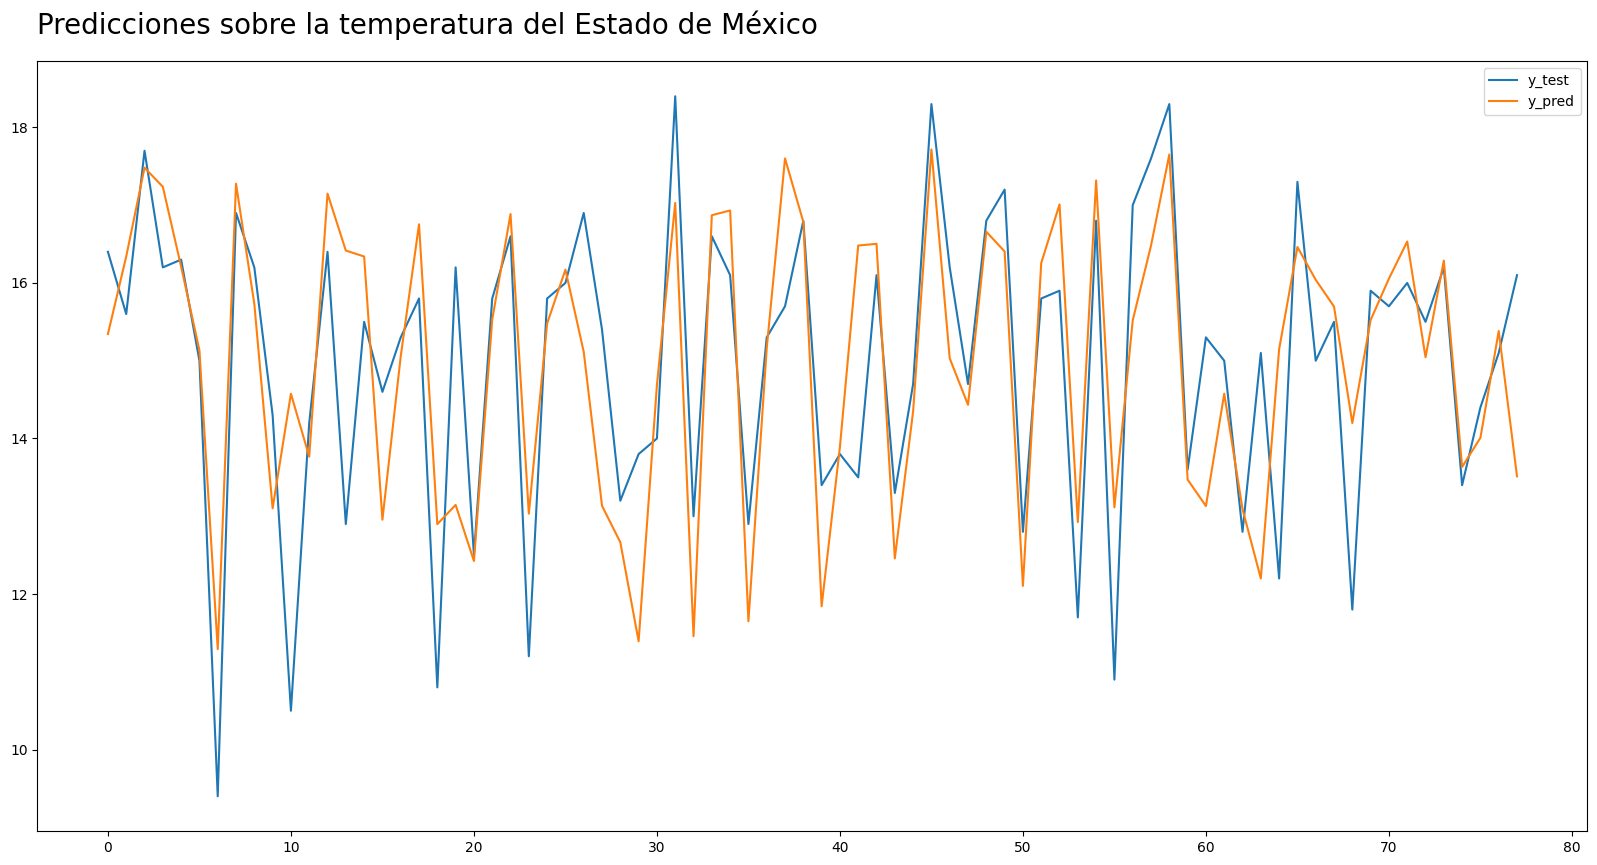

In [49]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre la temperatura del Estado de México', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [50]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [51]:
mae, rmse

(1.0264966, 1.3838997)

**GridSearchCV**

In [52]:
# Define a range of hyperparameter values for the grid search
params_values = [0.1, 0.01, 0.001, 0.0001, 0.009, 0.007, 0.005, 0.006]
reg_values = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0.02, 0.03, 0.04, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002]
kernels = ['gaussian']

# Initialize variables to store the best hyperparameters and model performance
best_params = None
best_score = float('inf')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Perform grid search
for params_value in params_values:
    for reg_value in reg_values:
        # Create a new instance of the KernelRidgeRegression class with current hyperparameters
        model = KernelRidgeRegression(params=params_value, reg_value=reg_value, kernel='gaussian')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        media = scaler_y.mean_[0]
        desviacion = scaler_y.scale_[0]

        y_pred = (y_pred * desviacion) + media
        
        # Evaluate the performance using a metric (e.g., mean squared error)
        score = mean_absolute_error(y_test, y_pred)

        # Check if the current set of hyperparameters gives a better performance
        if score < best_score:
            best_score = score
            best_params = {'params': params_value, 'reg_value': reg_value, 'kernel': 'gaussian'}

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'params': 0.1, 'reg_value': 0.0001, 'kernel': 'gaussian'}
Best Mean Squared Error: 1.0264966


#### Temperatura Puebla

In [53]:
# Todos los datos financieros y de coches
X = jnp.array(datos_regreso[cols], dtype=np.float32)

# La primera será la temperatura nacional
y = jnp.array(datos_regreso['PUE_temperatura'], dtype=np.float32)

* Hacemos una separación de los datos para entrenamiento y prueba

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [55]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.3, reg_value=0.001)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

In [56]:
media = scaler_y.mean_[0]
desviacion = scaler_y.scale_[0]

y_test = (y_test * desviacion) + media
y_pred_original_test = (y_pred_original_test * desviacion) + media

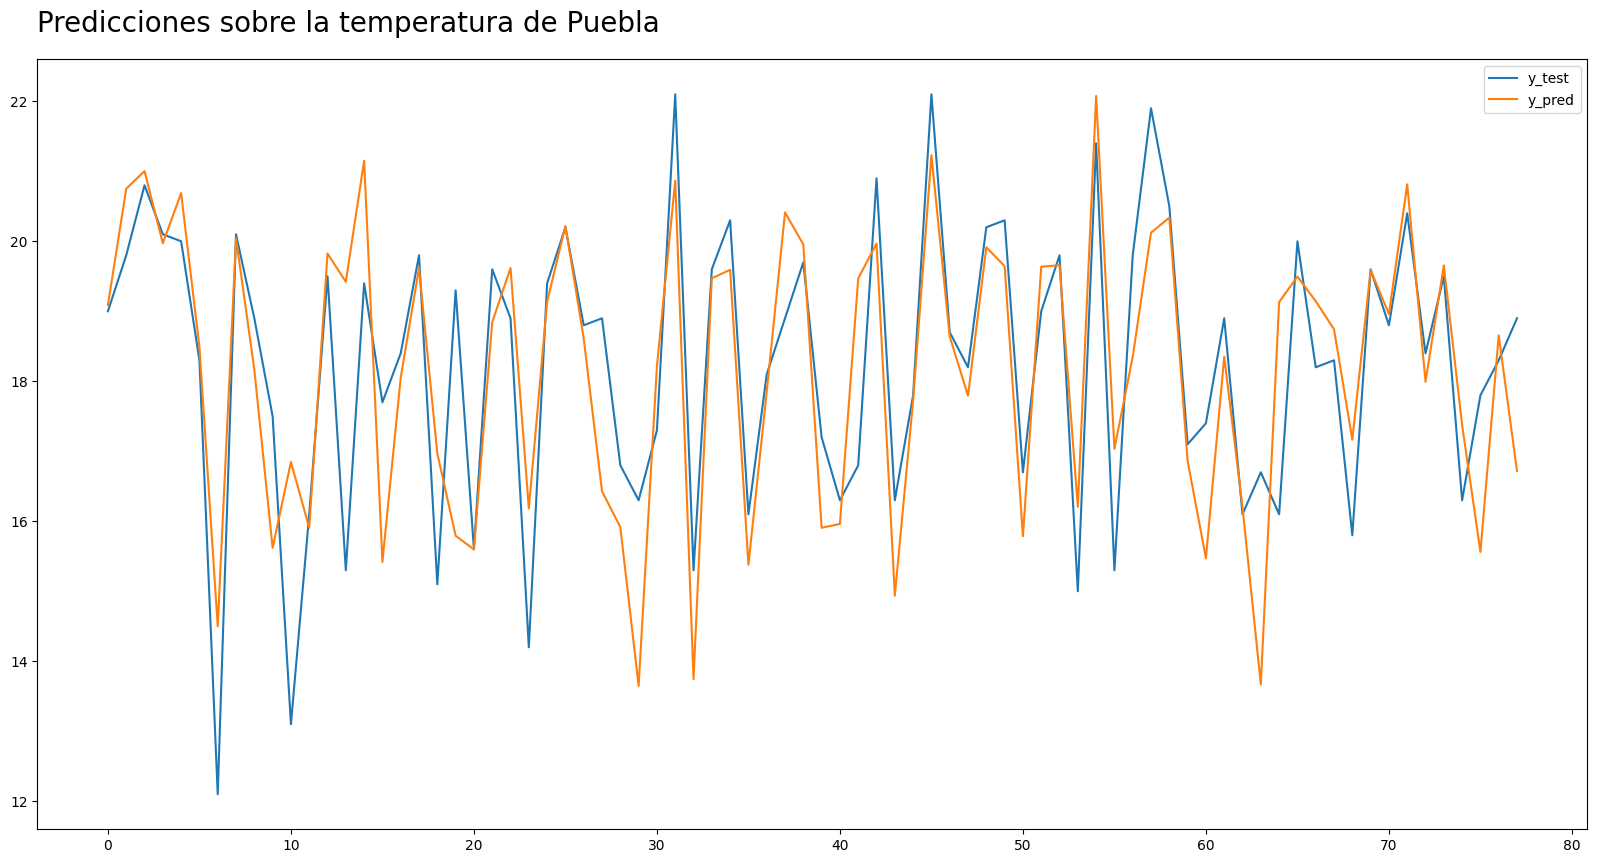

In [57]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre la temperatura de Puebla', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [58]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [59]:
mae, rmse

(1.0208962, 1.4125061)

**GridSearchCV**

In [60]:
# Define a range of hyperparameter values for the grid search
params_values = [0.1, 0.01, 0.001, 0.0001, 0.009, 0.007, 0.005, 0.006, 0.2, 0.3, 0.4, 0.5]
reg_values = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0.02, 0.03, 0.04, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002]
kernels = ['gaussian']

# Initialize variables to store the best hyperparameters and model performance
best_params = None
best_score = float('inf')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Perform grid search
for params_value in params_values:
    for reg_value in reg_values:
        # Create a new instance of the KernelRidgeRegression class with current hyperparameters
        model = KernelRidgeRegression(params=params_value, reg_value=reg_value, kernel='gaussian')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        media = scaler_y.mean_[0]
        desviacion = scaler_y.scale_[0]

        y_pred = (y_pred * desviacion) + media
        
        # Evaluate the performance using a metric (e.g., mean squared error)
        score = mean_absolute_error(y_test, y_pred)

        # Check if the current set of hyperparameters gives a better performance
        if score < best_score:
            best_score = score
            best_params = {'params': params_value, 'reg_value': reg_value, 'kernel': 'gaussian'}

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'params': 0.3, 'reg_value': 0.001, 'kernel': 'gaussian'}
Best Mean Squared Error: 1.0208962


#### Temperatura Nuevo León

In [61]:
# Todos los datos financieros y de coches
X = jnp.array(datos_regreso[cols], dtype=np.float32)

# La primera será la temperatura nacional
y = jnp.array(datos_regreso['NL_temperatura'], dtype=np.float32)

* Hacemos una separación de los datos para entrenamiento y prueba

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [63]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.01, reg_value=0.003)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

In [64]:
media = scaler_y.mean_[0]
desviacion = scaler_y.scale_[0]

y_test = (y_test * desviacion) + media
y_pred_original_test = (y_pred_original_test * desviacion) + media

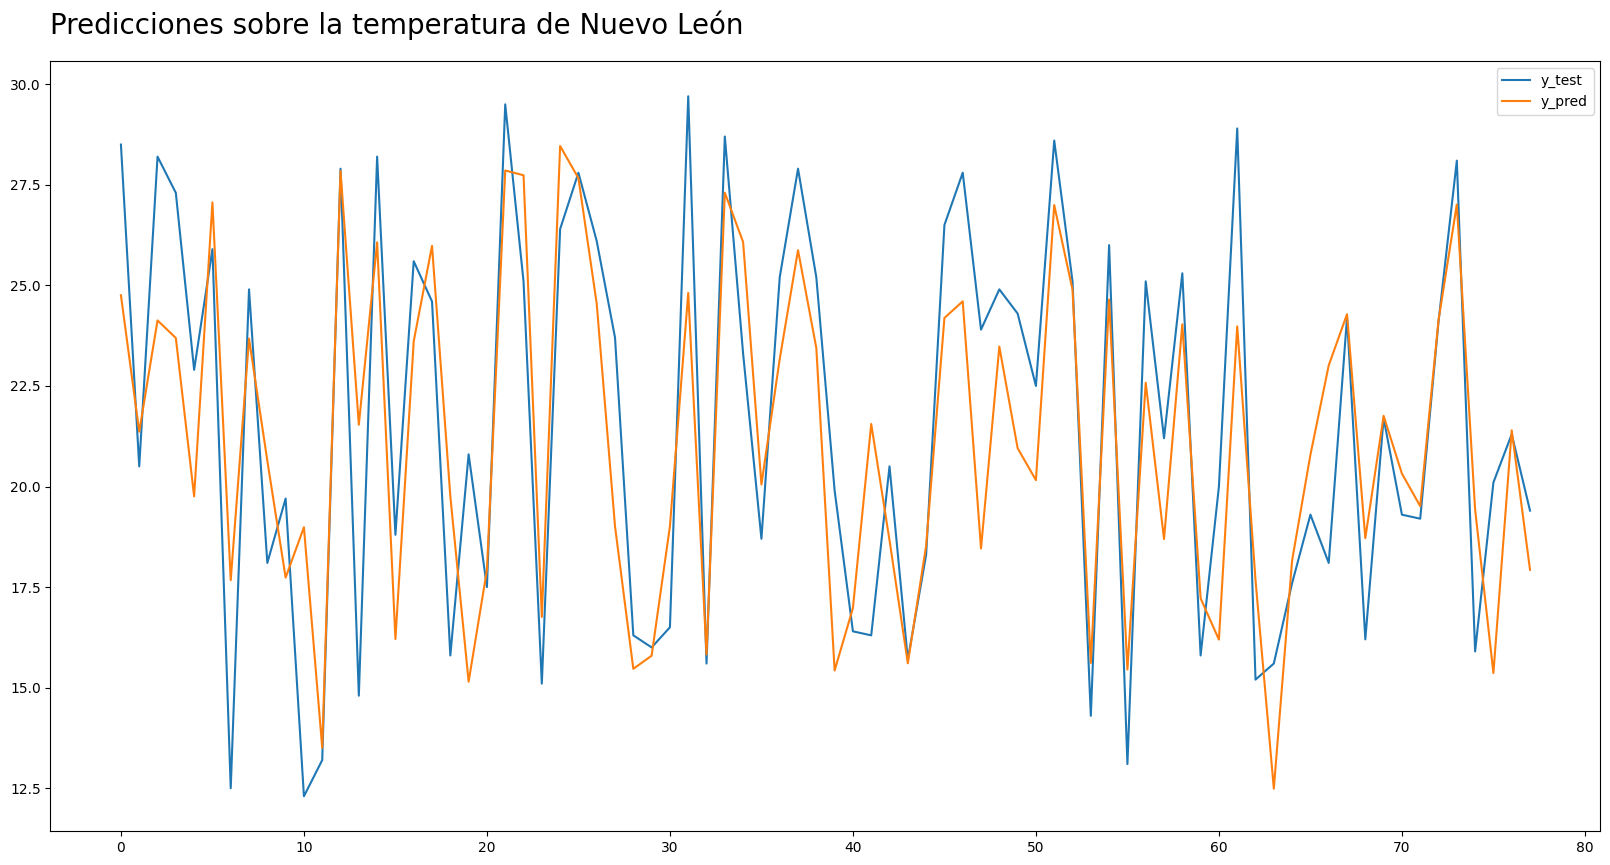

In [65]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre la temperatura de Nuevo León', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [66]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [67]:
mae, rmse

(2.244553, 2.8061838)

**GridSearchCV**

In [68]:
# Define a range of hyperparameter values for the grid search
params_values = [0.1, 0.01, 0.001, 0.0001, 0.009, 0.007, 0.005, 0.006, 0.2, 0.3, 0.4, 0.5]
reg_values = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0.02, 0.03, 0.04, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002]
kernels = ['gaussian']

# Initialize variables to store the best hyperparameters and model performance
best_params = None
best_score = float('inf')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Perform grid search
for params_value in params_values:
    for reg_value in reg_values:
        # Create a new instance of the KernelRidgeRegression class with current hyperparameters
        model = KernelRidgeRegression(params=params_value, reg_value=reg_value, kernel='gaussian')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        media = scaler_y.mean_[0]
        desviacion = scaler_y.scale_[0]

        y_pred = (y_pred * desviacion) + media
        
        # Evaluate the performance using a metric (e.g., mean squared error)
        score = mean_absolute_error(y_test, y_pred)

        # Check if the current set of hyperparameters gives a better performance
        if score < best_score:
            best_score = score
            best_params = {'params': params_value, 'reg_value': reg_value, 'kernel': 'gaussian'}

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'params': 0.01, 'reg_value': 0.003, 'kernel': 'gaussian'}
Best Mean Squared Error: 2.244553


#### Temperatura Sinaloa

In [69]:
# Todos los datos financieros y de coches
X = jnp.array(datos_regreso[cols], dtype=np.float32)

# La primera será la temperatura nacional
y = jnp.array(datos_regreso['SIN_temperatura'], dtype=np.float32)

* Hacemos una separación de los datos para entrenamiento y prueba

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [71]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.01, reg_value=0.008)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

In [72]:
media = scaler_y.mean_[0]
desviacion = scaler_y.scale_[0]

y_test = (y_test * desviacion) + media
y_pred_original_test = (y_pred_original_test * desviacion) + media

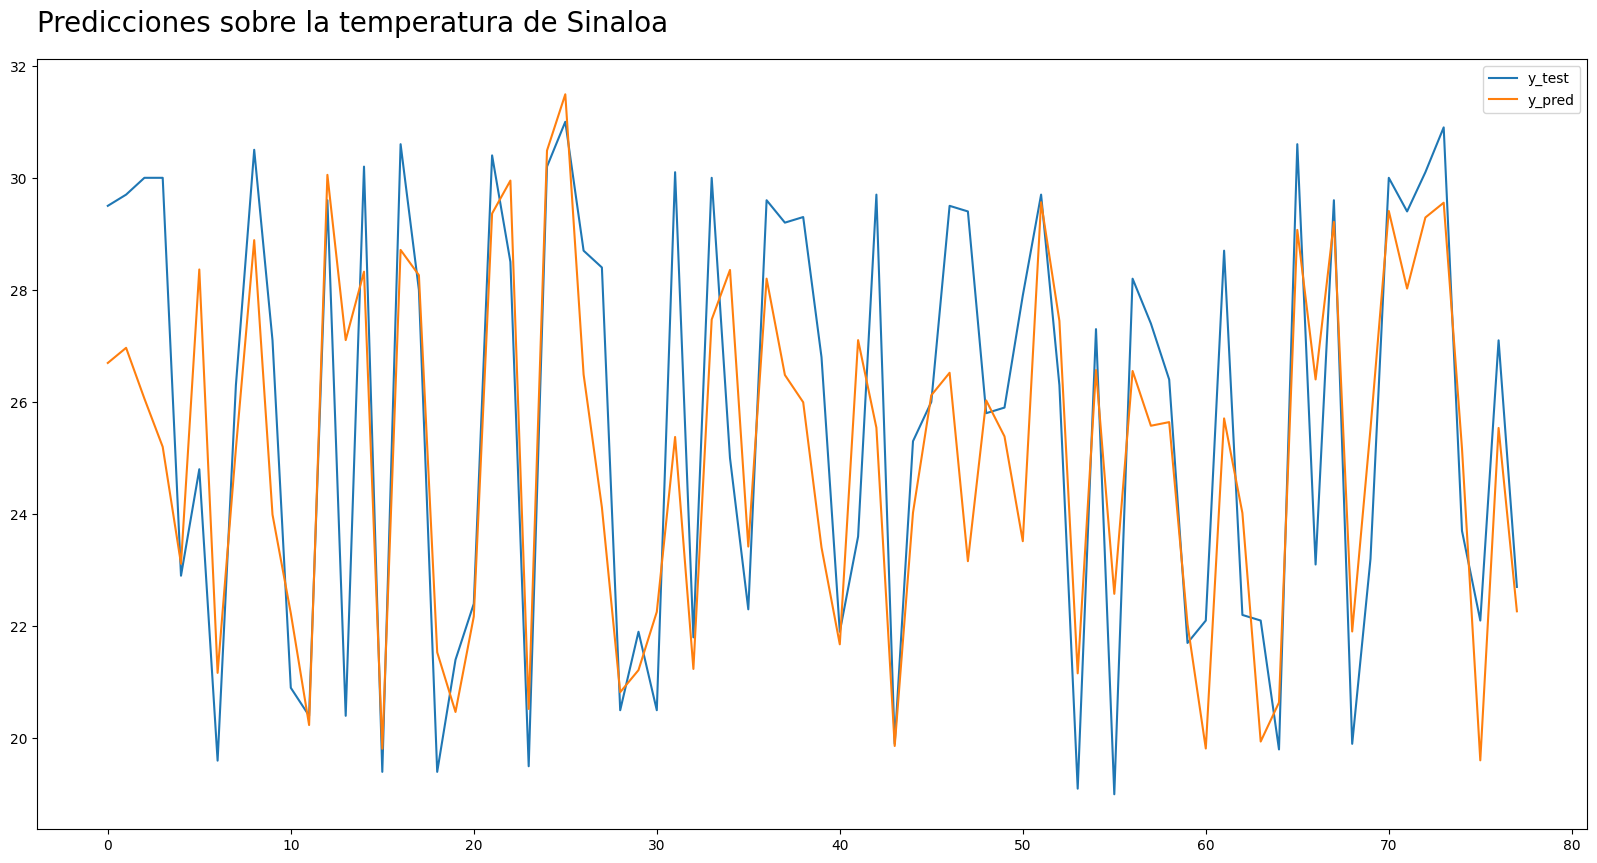

In [73]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre la temperatura de Sinaloa', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [74]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [75]:
mae, rmse

(1.8475219, 2.3554316)

**GridSearchCV**

In [76]:
# Define a range of hyperparameter values for the grid search
params_values = [0.1, 0.01, 0.001, 0.0001, 0.009, 0.007, 0.005, 0.006, 0.2, 0.3, 0.4, 0.5, 0.09]
reg_values = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0.02, 0.03, 0.04, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002]
kernels = ['gaussian']

# Initialize variables to store the best hyperparameters and model performance
best_params = None
best_score = float('inf')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Perform grid search
for params_value in params_values:
    for reg_value in reg_values:
        # Create a new instance of the KernelRidgeRegression class with current hyperparameters
        model = KernelRidgeRegression(params=params_value, reg_value=reg_value, kernel='gaussian')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        media = scaler_y.mean_[0]
        desviacion = scaler_y.scale_[0]

        y_pred = (y_pred * desviacion) + media
        
        # Evaluate the performance using a metric (e.g., mean squared error)
        score = mean_absolute_error(y_test, y_pred)

        # Check if the current set of hyperparameters gives a better performance
        if score < best_score:
            best_score = score
            best_params = {'params': params_value, 'reg_value': reg_value, 'kernel': 'gaussian'}

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'params': 0.01, 'reg_value': 0.008, 'kernel': 'gaussian'}
Best Mean Squared Error: 1.8475219


#### Temperatura Quintana Roo

In [77]:
# Todos los datos financieros y de coches
X = jnp.array(datos_regreso[cols], dtype=np.float32)

# La primera será la temperatura nacional
y = jnp.array(datos_regreso['QROO_temperatura'], dtype=np.float32)

* Hacemos una separación de los datos para entrenamiento y prueba

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [79]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.1, reg_value=0.04)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

In [80]:
media = scaler_y.mean_[0]
desviacion = scaler_y.scale_[0]

y_test = (y_test * desviacion) + media
y_pred_original_test = (y_pred_original_test * desviacion) + media

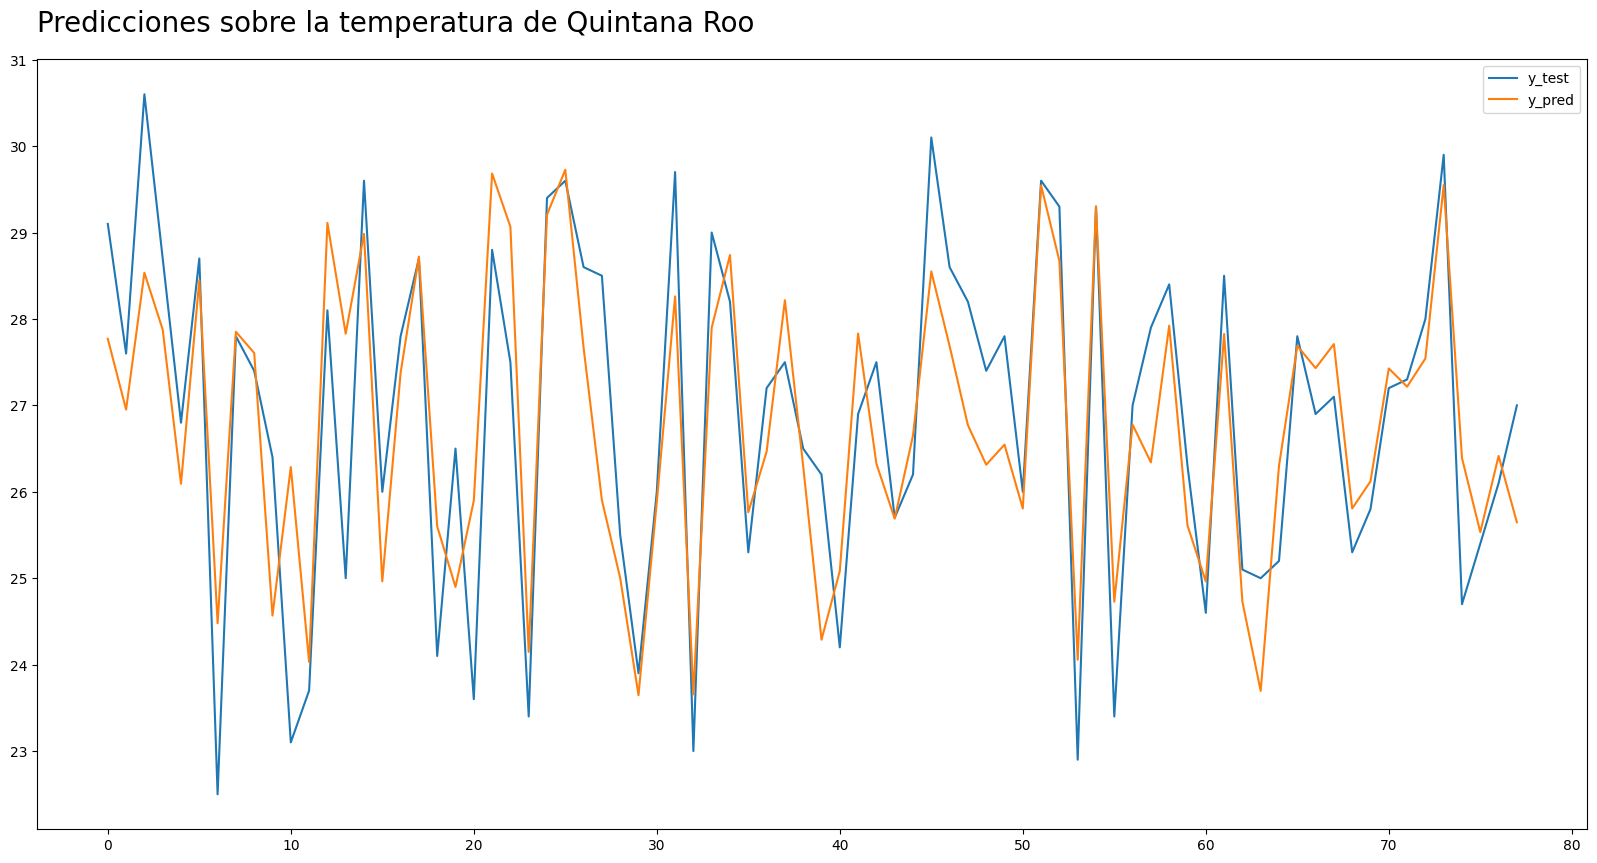

In [81]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre la temperatura de Quintana Roo', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [82]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [83]:
mae, rmse

(0.85811955, 1.1013886)

**GridSearchCV**

In [84]:
# Define a range of hyperparameter values for the grid search
params_values = [0.1, 0.01, 0.001, 0.0001, 0.009, 0.007, 0.005, 0.006, 0.2, 0.3, 0.4, 0.5]
reg_values = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0.02, 0.03, 0.04, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002]
kernels = ['gaussian']

# Initialize variables to store the best hyperparameters and model performance
best_params = None
best_score = float('inf')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Perform grid search
for params_value in params_values:
    for reg_value in reg_values:
        # Create a new instance of the KernelRidgeRegression class with current hyperparameters
        model = KernelRidgeRegression(params=params_value, reg_value=reg_value, kernel='gaussian')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        media = scaler_y.mean_[0]
        desviacion = scaler_y.scale_[0]

        y_pred = (y_pred * desviacion) + media
        
        # Evaluate the performance using a metric (e.g., mean squared error)
        score = mean_absolute_error(y_test, y_pred)

        # Check if the current set of hyperparameters gives a better performance
        if score < best_score:
            best_score = score
            best_params = {'params': params_value, 'reg_value': reg_value, 'kernel': 'gaussian'}

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'params': 0.1, 'reg_value': 0.04, 'kernel': 'gaussian'}
Best Mean Squared Error: 0.85811955


#### Temperatura Yucatán

In [85]:
# Todos los datos financieros y de coches
X = jnp.array(datos_regreso[cols], dtype=np.float32)

# La primera será la temperatura nacional
y = jnp.array(datos_regreso['YUC_temperatura'], dtype=np.float32)

* Hacemos una separación de los datos para entrenamiento y prueba

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [87]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.1, reg_value=0.04)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

In [88]:
media = scaler_y.mean_[0]
desviacion = scaler_y.scale_[0]

y_test = (y_test * desviacion) + media
y_pred_original_test = (y_pred_original_test * desviacion) + media

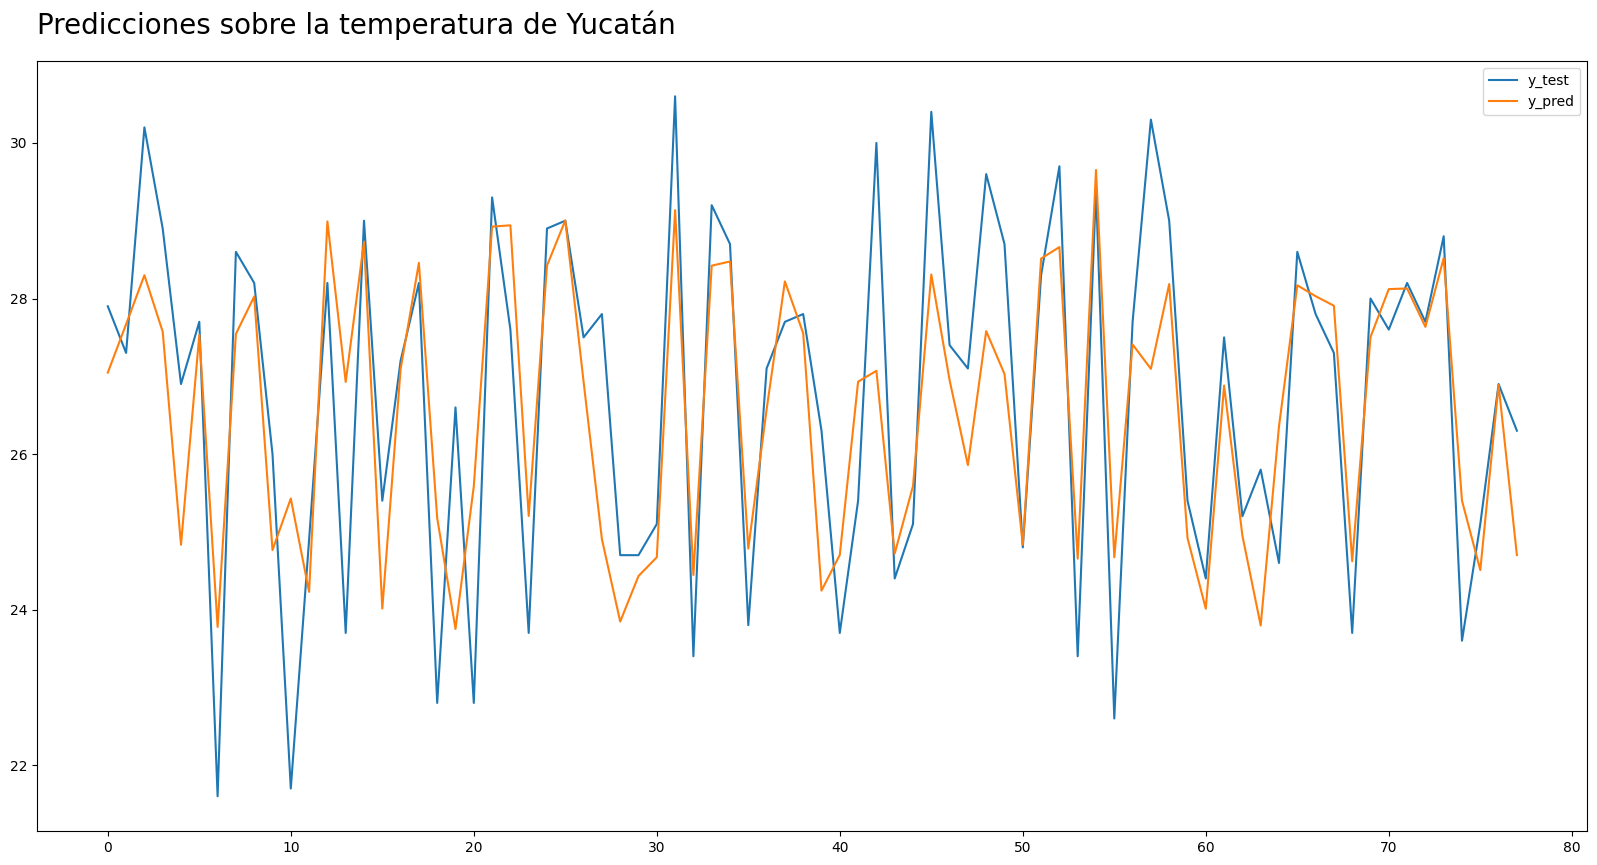

In [89]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre la temperatura de Yucatán', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [90]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [91]:
mae, rmse

(1.0562049, 1.3877538)

**GridSearchCV**

In [92]:
# Define a range of hyperparameter values for the grid search
params_values = [0.1, 0.01, 0.001, 0.0001, 0.009, 0.007, 0.005, 0.006, 0.2, 0.3, 0.4, 0.5]
reg_values = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0.02, 0.03, 0.04, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002]
kernels = ['gaussian']

# Initialize variables to store the best hyperparameters and model performance
best_params = None
best_score = float('inf')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Perform grid search
for params_value in params_values:
    for reg_value in reg_values:
        # Create a new instance of the KernelRidgeRegression class with current hyperparameters
        model = KernelRidgeRegression(params=params_value, reg_value=reg_value, kernel='gaussian')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        media = scaler_y.mean_[0]
        desviacion = scaler_y.scale_[0]

        y_pred = (y_pred * desviacion) + media
        
        # Evaluate the performance using a metric (e.g., mean squared error)
        score = mean_absolute_error(y_test, y_pred)

        # Check if the current set of hyperparameters gives a better performance
        if score < best_score:
            best_score = score
            best_params = {'params': params_value, 'reg_value': reg_value, 'kernel': 'gaussian'}

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'params': 0.1, 'reg_value': 0.04, 'kernel': 'gaussian'}
Best Mean Squared Error: 1.0562049


#### Temperatura San Luis Potosí

In [93]:
# Todos los datos financieros y de coches
X = jnp.array(datos_regreso[cols], dtype=np.float32)

# La primera será la temperatura nacional
y = jnp.array(datos_regreso['SLP_temperatura'], dtype=np.float32)

* Hacemos una separación de los datos para entrenamiento y prueba

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [95]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.1, reg_value=0.04)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

In [96]:
media = scaler_y.mean_[0]
desviacion = scaler_y.scale_[0]

y_test = (y_test * desviacion) + media
y_pred_original_test = (y_pred_original_test * desviacion) + media

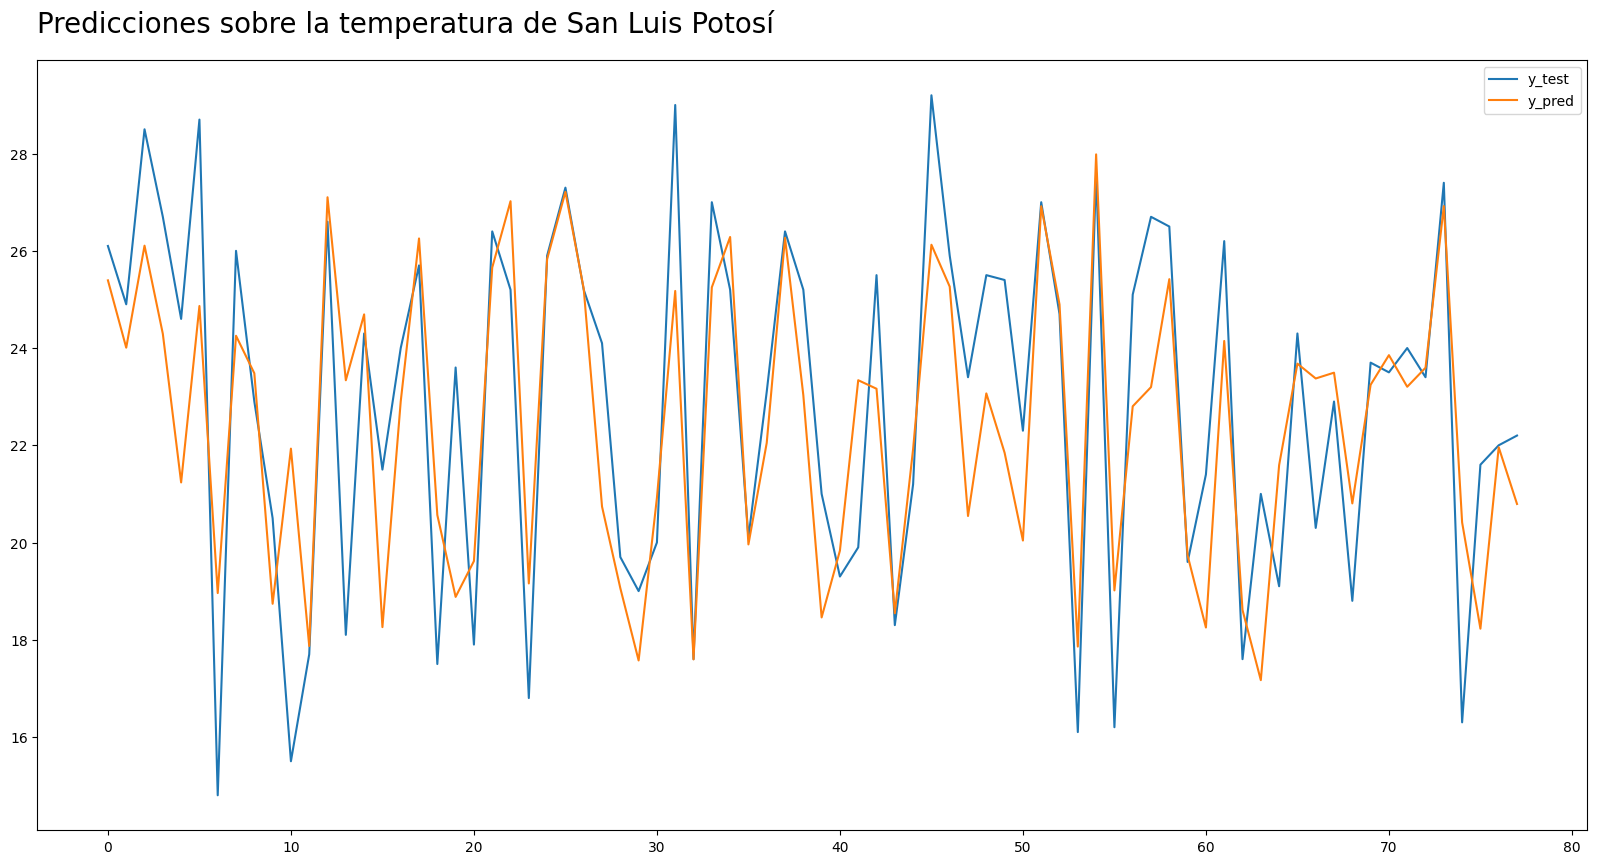

In [97]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre la temperatura de San Luis Potosí', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [98]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [99]:
mae, rmse

(1.7629331, 2.2793207)

**GridSearchCV**

In [100]:
# Define a range of hyperparameter values for the grid search
params_values = [0.1, 0.01, 0.001, 0.0001, 0.009, 0.007, 0.005, 0.006, 0.2, 0.3, 0.4, 0.5]
reg_values = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0.02, 0.03, 0.04, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002]
kernels = ['gaussian']

# Initialize variables to store the best hyperparameters and model performance
best_params = None
best_score = float('inf')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Perform grid search
for params_value in params_values:
    for reg_value in reg_values:
        # Create a new instance of the KernelRidgeRegression class with current hyperparameters
        model = KernelRidgeRegression(params=params_value, reg_value=reg_value, kernel='gaussian')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        media = scaler_y.mean_[0]
        desviacion = scaler_y.scale_[0]

        y_pred = (y_pred * desviacion) + media
        
        # Evaluate the performance using a metric (e.g., mean squared error)
        score = mean_absolute_error(y_test, y_pred)

        # Check if the current set of hyperparameters gives a better performance
        if score < best_score:
            best_score = score
            best_params = {'params': params_value, 'reg_value': reg_value, 'kernel': 'gaussian'}

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'params': 0.1, 'reg_value': 0.04, 'kernel': 'gaussian'}
Best Mean Squared Error: 1.7629331


#### Lluvia Nacional

In [101]:
# Todos los datos financieros y de coches
X = jnp.array(datos_regreso[cols], dtype=np.float32)

# La primera será la lluvia nacional
y = jnp.array(datos_regreso['NACIONAL_lluvia'], dtype=np.float32)

* Hacemos una separación de los datos para entrenamiento y prueba

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [103]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.009, reg_value=0.008)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

In [104]:
media = scaler_y.mean_[0]
desviacion = scaler_y.scale_[0]

y_test = (y_test * desviacion) + media
y_pred_original_test = (y_pred_original_test * desviacion) + media

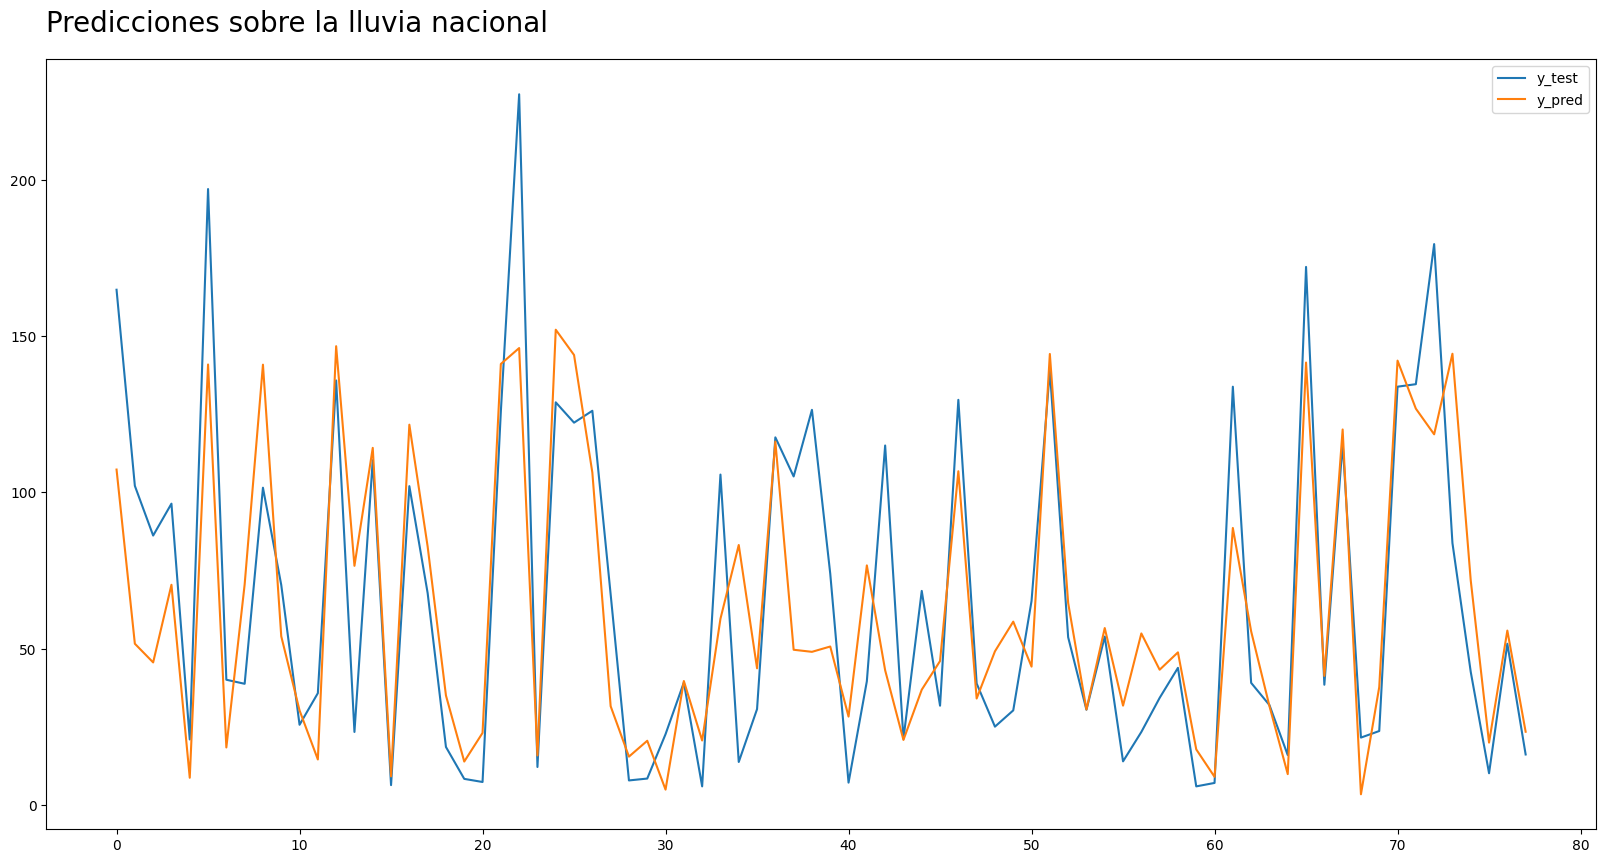

In [105]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre la lluvia nacional', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [106]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [107]:
mae, rmse

(22.554369, 30.15665)

**GridSearchCV**

In [108]:
# Define a range of hyperparameter values for the grid search
params_values = [0.1, 0.01, 0.001, 0.0001, 0.02, 0.03, 0.04, 0.009]
reg_values = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0.02, 0.03, 0.04, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002]
kernels = ['gaussian']

# Initialize variables to store the best hyperparameters and model performance
best_params = None
best_score = float('inf')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Perform grid search
for params_value in params_values:
    for reg_value in reg_values:
        # Create a new instance of the KernelRidgeRegression class with current hyperparameters
        model = KernelRidgeRegression(params=params_value, reg_value=reg_value, kernel='gaussian')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        y_pred = (y_pred * desviacion) + media
        
        # Evaluate the performance using a metric (e.g., mean squared error)
        score = mean_absolute_error(y_test, y_pred)

        # Check if the current set of hyperparameters gives a better performance
        if score < best_score:
            best_score = score
            best_params = {'params': params_value, 'reg_value': reg_value, 'kernel': 'gaussian'}

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'params': 0.009, 'reg_value': 0.008, 'kernel': 'gaussian'}
Best Mean Squared Error: 22.554369


#### Lluvia Colima

In [109]:
# Todos los datos financieros y de coches
X = jnp.array(datos_regreso[cols], dtype=np.float32)

# La primera será la lluvia nacional
y = jnp.array(datos_regreso['COL_lluvia'], dtype=np.float32)

* Hacemos una separación de los datos para entrenamiento y prueba

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [111]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.0001, reg_value=0.0001)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

In [112]:
media = scaler_y.mean_[0]
desviacion = scaler_y.scale_[0]

y_test = (y_test * desviacion) + media
y_pred_original_test = (y_pred_original_test * desviacion) + media

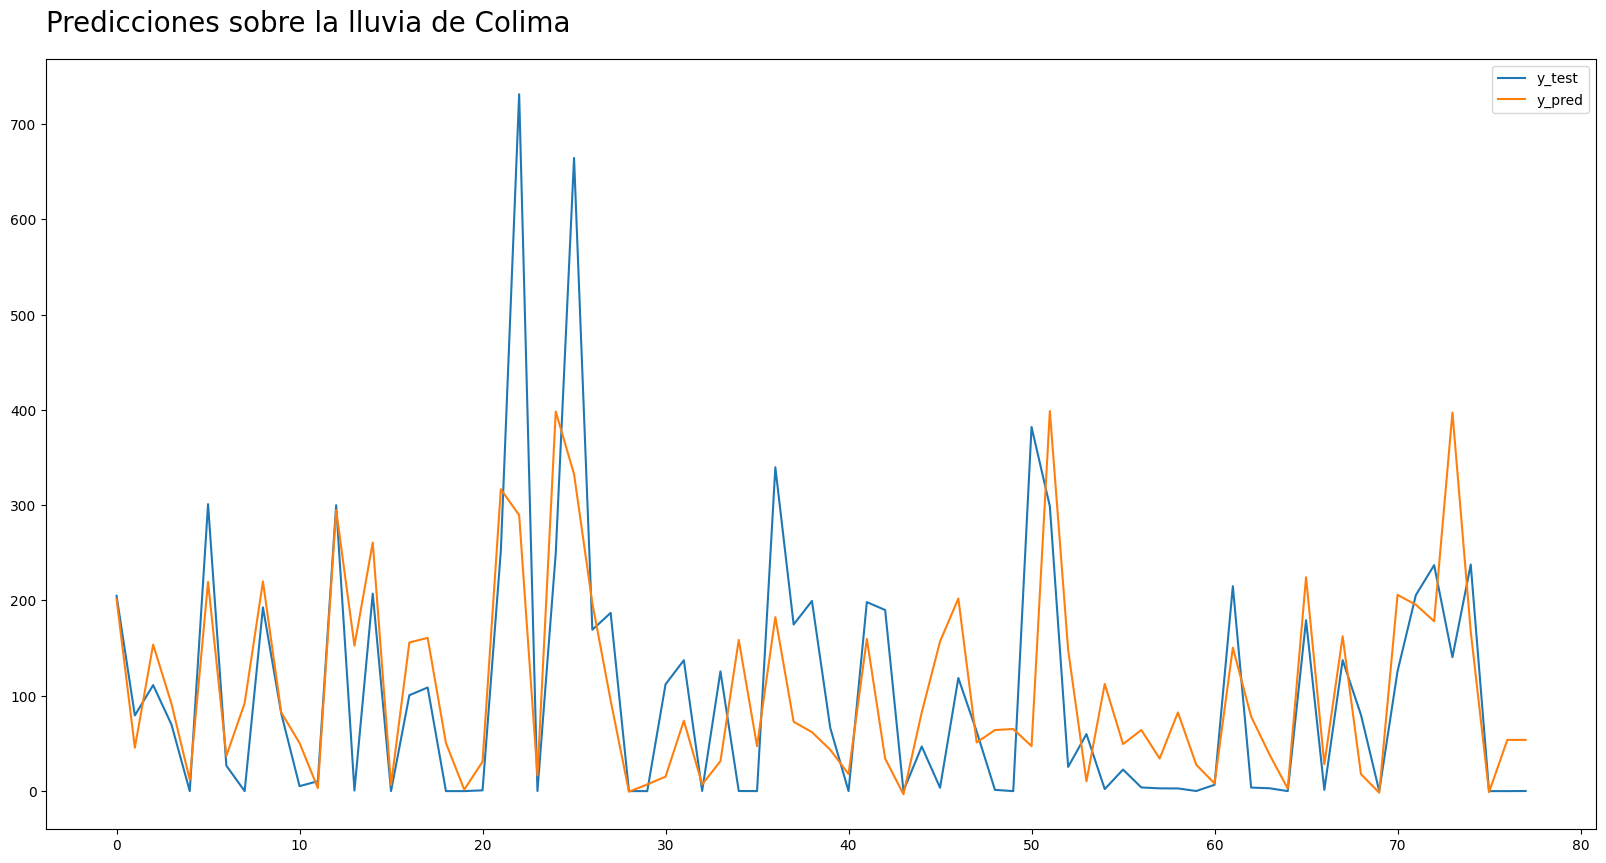

In [113]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre la lluvia de Colima', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [114]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [115]:
mae, rmse

(67.91536, 103.615074)

**GridSearchCV**

In [116]:
# Define a range of hyperparameter values for the grid search
params_values = [0.1, 0.01, 0.001, 0.0001, 0.02, 0.03, 0.04, 0.009]
reg_values = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0.02, 0.03, 0.04, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002]
kernels = ['gaussian']

# Initialize variables to store the best hyperparameters and model performance
best_params = None
best_score = float('inf')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Perform grid search
for params_value in params_values:
    for reg_value in reg_values:
        # Create a new instance of the KernelRidgeRegression class with current hyperparameters
        model = KernelRidgeRegression(params=params_value, reg_value=reg_value, kernel='gaussian')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        y_pred = (y_pred * desviacion) + media
        
        # Evaluate the performance using a metric (e.g., mean squared error)
        score = mean_absolute_error(y_test, y_pred)

        # Check if the current set of hyperparameters gives a better performance
        if score < best_score:
            best_score = score
            best_params = {'params': params_value, 'reg_value': reg_value, 'kernel': 'gaussian'}

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'params': 0.0001, 'reg_value': 0.0001, 'kernel': 'gaussian'}
Best Mean Squared Error: 67.91536


#### Lluvia Quintana Roo

In [117]:
# Todos los datos financieros y de coches
X = jnp.array(datos_regreso[cols], dtype=np.float32)

# La primera será la lluvia nacional
y = jnp.array(datos_regreso['QROO_lluvia'], dtype=np.float32)

* Hacemos una separación de los datos para entrenamiento y prueba

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [119]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.001, reg_value=0.007)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

In [120]:
media = scaler_y.mean_[0]
desviacion = scaler_y.scale_[0]

y_test = (y_test * desviacion) + media
y_pred_original_test = (y_pred_original_test * desviacion) + media

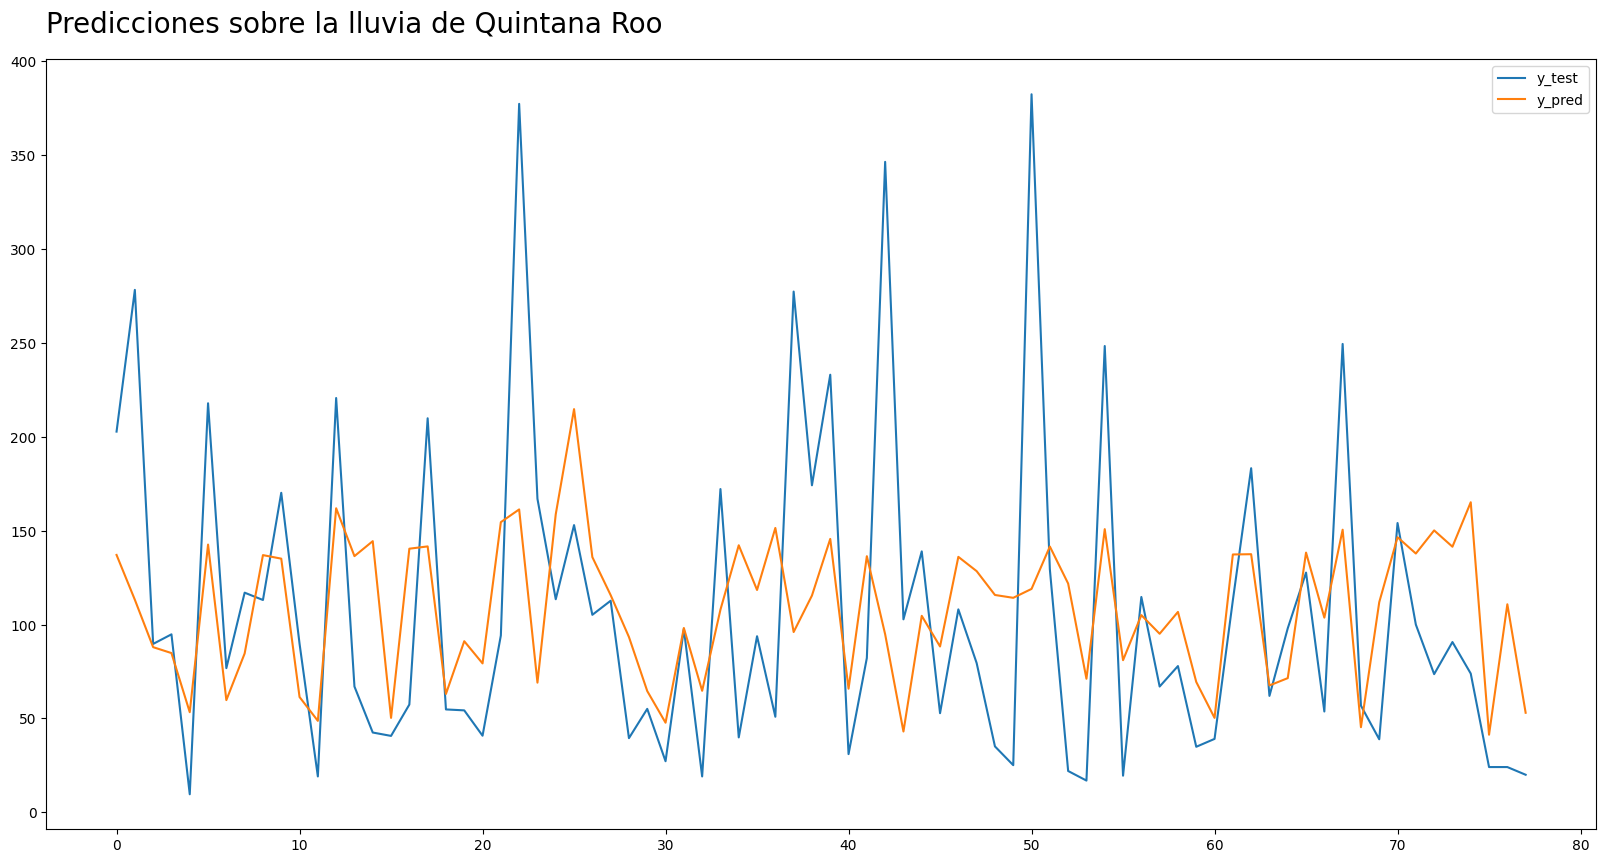

In [121]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre la lluvia de Quintana Roo', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [122]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [123]:
mae, rmse

(56.831257, 76.56804)

**GridSearchCV**

In [124]:
# Define a range of hyperparameter values for the grid search
params_values = [0.1, 0.01, 0.001, 0.0001, 0.02, 0.03, 0.04, 0.009]
reg_values = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0.02, 0.03, 0.04, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002]
kernels = ['gaussian']

# Initialize variables to store the best hyperparameters and model performance
best_params = None
best_score = float('inf')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Perform grid search
for params_value in params_values:
    for reg_value in reg_values:
        # Create a new instance of the KernelRidgeRegression class with current hyperparameters
        model = KernelRidgeRegression(params=params_value, reg_value=reg_value, kernel='gaussian')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        y_pred = (y_pred * desviacion) + media
        
        # Evaluate the performance using a metric (e.g., mean squared error)
        score = mean_absolute_error(y_test, y_pred)

        # Check if the current set of hyperparameters gives a better performance
        if score < best_score:
            best_score = score
            best_params = {'params': params_value, 'reg_value': reg_value, 'kernel': 'gaussian'}

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'params': 0.001, 'reg_value': 0.007, 'kernel': 'gaussian'}
Best Mean Squared Error: 56.831257


#### Lluvia Chiapas

In [125]:
# Todos los datos financieros y de coches
X = jnp.array(datos_regreso[cols], dtype=np.float32)

# La primera será la lluvia nacional
y = jnp.array(datos_regreso['CHIS_lluvia'], dtype=np.float32)

* Hacemos una separación de los datos para entrenamiento y prueba

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [127]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.009, reg_value=0.005)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

In [128]:
media = scaler_y.mean_[0]
desviacion = scaler_y.scale_[0]

y_test = (y_test * desviacion) + media
y_pred_original_test = (y_pred_original_test * desviacion) + media

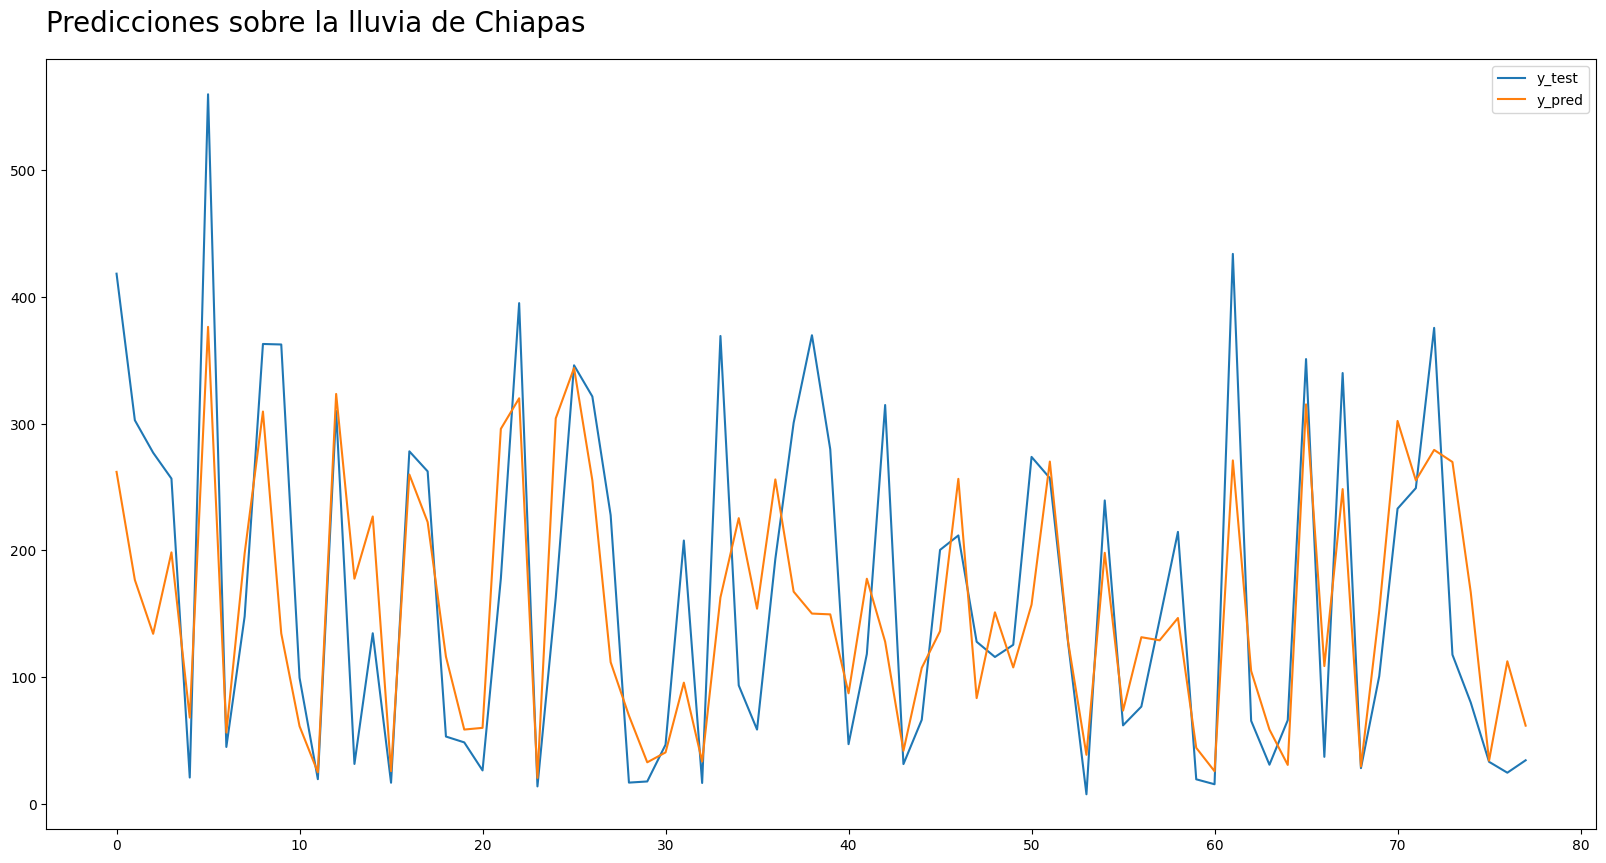

In [129]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre la lluvia de Chiapas', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [130]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [131]:
mae, rmse

(66.732635, 87.82864)

**GridSearchCV**

In [132]:
# Define a range of hyperparameter values for the grid search
params_values = [0.1, 0.01, 0.001, 0.0001, 0.02, 0.03, 0.04, 0.009]
reg_values = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0.02, 0.03, 0.04, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002]
kernels = ['gaussian']

# Initialize variables to store the best hyperparameters and model performance
best_params = None
best_score = float('inf')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Perform grid search
for params_value in params_values:
    for reg_value in reg_values:
        # Create a new instance of the KernelRidgeRegression class with current hyperparameters
        model = KernelRidgeRegression(params=params_value, reg_value=reg_value, kernel='gaussian')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        y_pred = (y_pred * desviacion) + media
        
        # Evaluate the performance using a metric (e.g., mean squared error)
        score = mean_absolute_error(y_test, y_pred)

        # Check if the current set of hyperparameters gives a better performance
        if score < best_score:
            best_score = score
            best_params = {'params': params_value, 'reg_value': reg_value, 'kernel': 'gaussian'}

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'params': 0.009, 'reg_value': 0.005, 'kernel': 'gaussian'}
Best Mean Squared Error: 66.732635


#### Lluvia Campeche

In [133]:
# Todos los datos financieros y de coches
X = jnp.array(datos_regreso[cols], dtype=np.float32)

# La primera será la lluvia nacional
y = jnp.array(datos_regreso['CAMP_lluvia'], dtype=np.float32)

* Hacemos una separación de los datos para entrenamiento y prueba

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [135]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.009, reg_value=0.01)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

In [136]:
media = scaler_y.mean_[0]
desviacion = scaler_y.scale_[0]

y_test = (y_test * desviacion) + media
y_pred_original_test = (y_pred_original_test * desviacion) + media

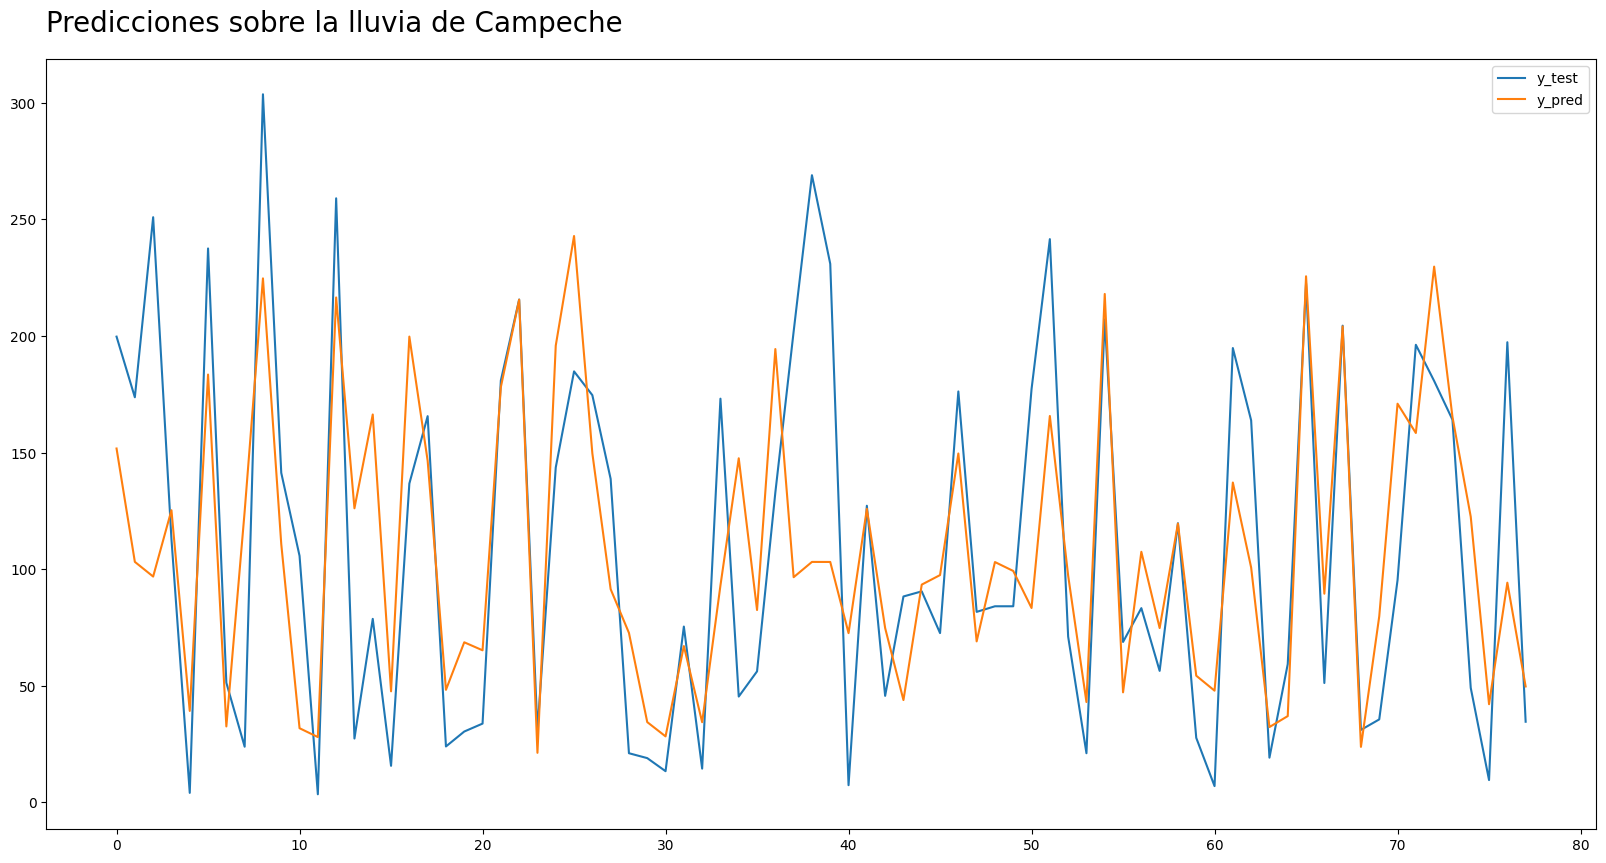

In [137]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre la lluvia de Campeche', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [138]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [139]:
mae, rmse

(42.962452, 55.77219)

**GridSearchCV**

In [140]:
# Define a range of hyperparameter values for the grid search
params_values = [0.1, 0.01, 0.001, 0.0001, 0.02, 0.03, 0.04, 0.009]
reg_values = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0.02, 0.03, 0.04, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002]
kernels = ['gaussian']

# Initialize variables to store the best hyperparameters and model performance
best_params = None
best_score = float('inf')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Perform grid search
for params_value in params_values:
    for reg_value in reg_values:
        # Create a new instance of the KernelRidgeRegression class with current hyperparameters
        model = KernelRidgeRegression(params=params_value, reg_value=reg_value, kernel='gaussian')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        y_pred = (y_pred * desviacion) + media
        
        # Evaluate the performance using a metric (e.g., mean squared error)
        score = mean_absolute_error(y_test, y_pred)

        # Check if the current set of hyperparameters gives a better performance
        if score < best_score:
            best_score = score
            best_params = {'params': params_value, 'reg_value': reg_value, 'kernel': 'gaussian'}

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'params': 0.009, 'reg_value': 0.01, 'kernel': 'gaussian'}
Best Mean Squared Error: 42.962452


#### Lluvia Morelos

In [141]:
# Todos los datos financieros y de coches
X = jnp.array(datos_regreso[cols], dtype=np.float32)

# La primera será la lluvia nacional
y = jnp.array(datos_regreso['MOR_lluvia'], dtype=np.float32)

* Hacemos una separación de los datos para entrenamiento y prueba

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

* Escalamos los datos

In [143]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scaled
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Creamos un objeto de Kernel Ridge Regression
krr = KernelRidgeRegression(kernel='gaussian', params=0.009, reg_value=0.01)

# Ajustamos nuestro modelos a los datos de entrenamiento
krr.fit(X_train, y_train)

y_pred_original_test = krr.predict(X_test)

In [144]:
media = scaler_y.mean_[0]
desviacion = scaler_y.scale_[0]

y_test = (y_test * desviacion) + media
y_pred_original_test = (y_pred_original_test * desviacion) + media

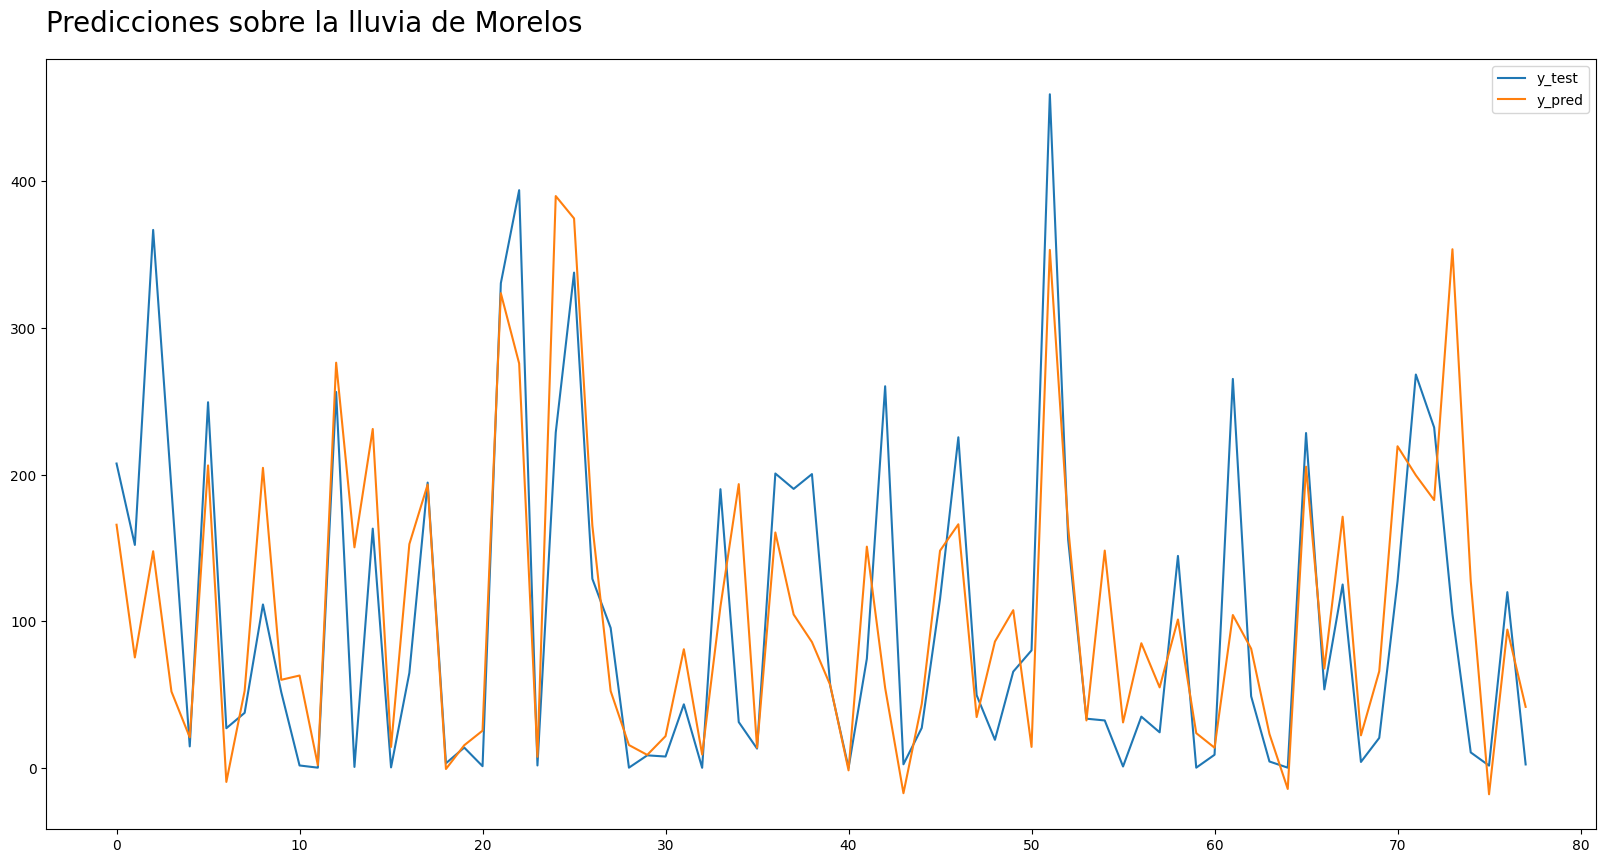

In [145]:
pd.DataFrame({'y_test': y_test.ravel(), 'y_pred': y_pred_original_test.ravel()}).plot(figsize=(20, 10))
plt.title('Predicciones sobre la lluvia de Morelos', fontsize=20, loc='left', pad=20)
plt.show()

* Evalúamos el error del modelo

In [146]:
mae = mean_absolute_error(y_test, y_pred_original_test)
rmse = mean_squared_error(y_test, y_pred_original_test, squared=False)

* Métricas

In [147]:
mae, rmse

(52.953743, 75.98079)

**GridSearchCV**

In [148]:
# Define a range of hyperparameter values for the grid search
params_values = [0.1, 0.01, 0.001, 0.0001, 0.02, 0.03, 0.04, 0.009]
reg_values = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0.02, 0.03, 0.04, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002]
kernels = ['gaussian']

# Initialize variables to store the best hyperparameters and model performance
best_params = None
best_score = float('inf')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Perform grid search
for params_value in params_values:
    for reg_value in reg_values:
        # Create a new instance of the KernelRidgeRegression class with current hyperparameters
        model = KernelRidgeRegression(params=params_value, reg_value=reg_value, kernel='gaussian')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        y_pred = (y_pred * desviacion) + media
        
        # Evaluate the performance using a metric (e.g., mean squared error)
        score = mean_absolute_error(y_test, y_pred)

        # Check if the current set of hyperparameters gives a better performance
        if score < best_score:
            best_score = score
            best_params = {'params': params_value, 'reg_value': reg_value, 'kernel': 'gaussian'}

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'params': 0.009, 'reg_value': 0.01, 'kernel': 'gaussian'}
Best Mean Squared Error: 52.953743
